In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import copy
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import os
import plotly.express as px
from matplotlib import cm
import matplotlib as mpl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import matplotlib as mpl
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy
import random
import xarray as xr
import itertools
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn import tree
from sklearn.model_selection import cross_validate
import geopandas as gpd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from pathos.threading import ThreadPool as Pool
from sklearn import datasets, linear_model
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

In [16]:
work_dir=Path("/mnt/u/LSM root zone/global_sr")
fig_dir=Path('/mnt/c/Users/fransjevanoors/surfdrive - Fransje van Oorschot@surfdrive.surf.nl/Fransje/global_SR/global_sr_paper/figures')

In [17]:
data_sources = 'gswp-p_gleam-ep_gswp-t'

In [18]:
# performance metrics
def rmse(y,y_pred):
    rmse = np.sqrt(mean_squared_error(y,y_pred))
    return rmse

def r2_adj(y,y_pred,features):
    r2 = r2_score(y, y_pred)
    r2_adj = 1-(((1-r2)*(len(y)-1))/(len(y)-len(features)-1))
    return r2_adj

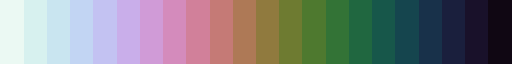

In [19]:
cmap = cm.get_cmap('cubehelix_r', 24)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmap_sr = ListedColormap(color_list[1:-1])
cmap_sr.set_over(color_list[-1])
cmap_sr.set_under(color_list[0])
cmap_sr.set_bad('lightgrey')
cmap_sr

In [20]:
# # change units of slope
# df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v2.csv',index_col=0)
# dfs = df.slp_mean
# dfs =  np.deg2rad(dfs)
# slp_p = np.tan(dfs) * 100
# df['slp_mean'] = slp_p
# df.to_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v3.csv')

## 0. plot Sr

3612


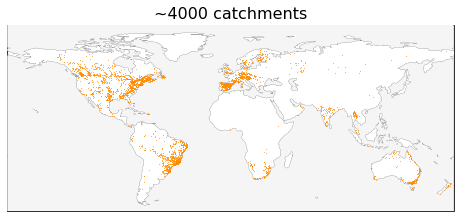

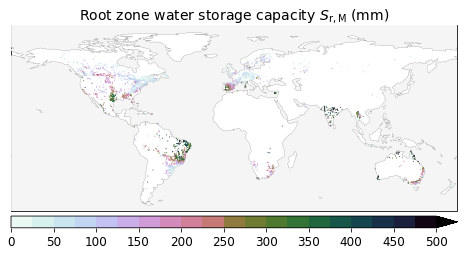

In [23]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
df = df[['lat','lon','sr_20']]
print(len(df))

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(df.lon,df.lat,s=0.7,c='darkorange',edgecolors='face',marker='o',linewidths=0.1,zorder=102)
ax.set_title('~4000 catchments',size=16)
fig2.savefig(f'{fig_dir}/catch_locations.jpg',bbox_inches='tight',dpi=600)

bounds = np.linspace(0,500,21)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,s=0.8,c=df['sr_20'],cmap=cmap_sr, norm=norm,edgecolors='face',marker='o',linewidths=0.1,zorder=101)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.012,aspect=38, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title('Root zone water storage capacity $S_\mathrm{r,M}$ (mm)',size=14)
cbar.set_label(label='', size=10)
fig.savefig(f'{fig_dir}/sr_memory_method.jpg',bbox_inches='tight',dpi=600)

## 1. CORRELATION MATRIX

In [24]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    # cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    # cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False,labelsize=17)

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #          rotation_mode="anchor")
    
    plt.setp(ax.get_xticklabels(), rotation=30, ha="center", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    # ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t_v3.csv'
df = pd.read_csv(f,index_col=0)
df = df.drop(columns=['stext','start_year','end_year','years','kg','lat','lon'])
df = df.drop(columns=['idu_mean_l', 'idu_max_l', 'hpd_mean_l',
       'hpd_max_l', 'hpf_l', 'lpf_l', 'si_pl', 'phi_l', 'de_l', 'dp_l', 'dt_l',
       'sp_l', 'st_l', 'se_l', 'sd_l', 'sti_l', 'asi_l','ppd_l'])
df = df.drop(columns=['sti','area'])
df = df.drop(columns=['q_mean'])
df = df.dropna()
corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)
corr.style.background_gradient(cmap='coolwarm').set_precision(2).to_excel(f'{work_dir}/output/regression/correlation_matrix.xlsx')

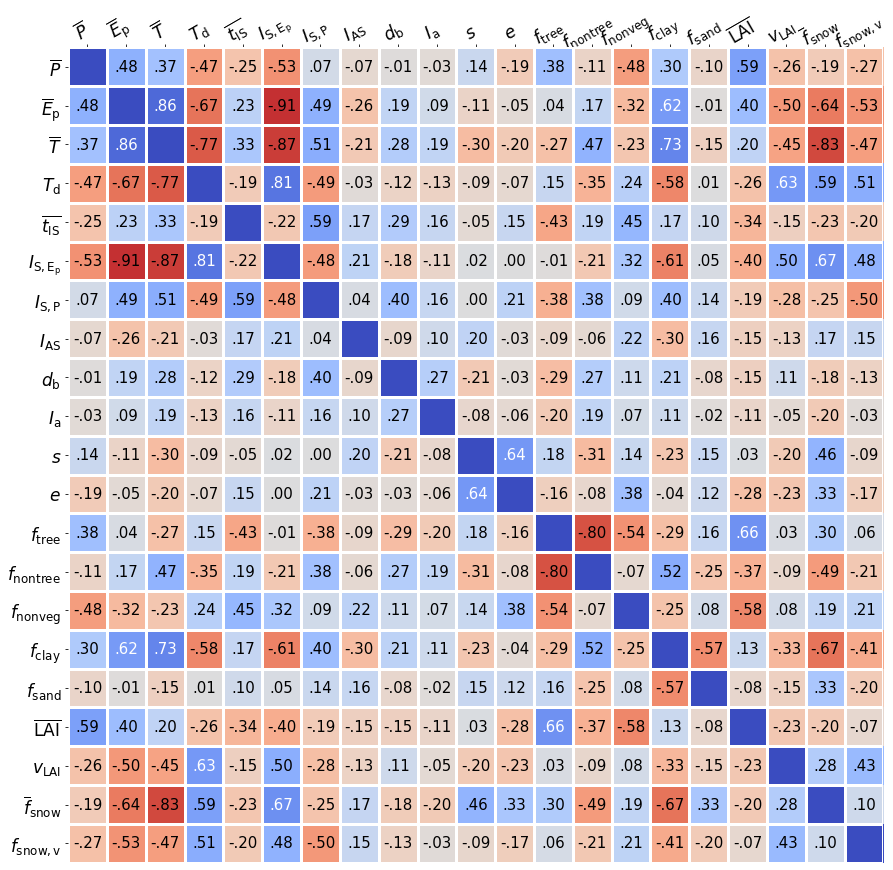

In [ ]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t_v3.csv'
df = pd.read_csv(f,index_col=0)
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
df = df[features]
df = df.dropna()
df = df.rename(columns={'idu_mean':'$\overline{t_\mathrm{IS}}$','tdiff_mean':'$T_{\mathrm{d}}$','t_mean':'$\overline{T}$', 'asi':'$I_{\mathrm{AS}}$','p_mean':'$\overline{P}$','si_p':'$I_{\mathrm{S,P}}$','ep_mean':'$\overline{E}_\mathrm{p}$',
                    'sc_mean':'$\overline{f}_{\mathrm{snow}}$','pclay':'$f_{\mathrm{clay}}$','slp_mean':'$s$','lai_mean':'$\overline{\mathrm{LAI}}$','ntc':'$f_{\mathrm{nontree}}$','dtb':'$d_{\mathrm{b}}$','si_ep':'$I_{\mathrm{S,E_p}}$',
                        'lai_rsd':'$v_\mathrm{LAI}$','nonveg':'$f_{\mathrm{nonveg}}$','el_mean':'$e$','psand':'$f_{\mathrm{sand}}$','sc_rsd':'$f_{\mathrm{snow,v}}$','tc':'$f_{\mathrm{tree}}$','ia':'$I_\mathrm{a}$'})
xl = df.columns
yl = df.columns

corr = df.corr()
fig, ax = plt.subplots(1,1,figsize=(15,15))
im = heatmap(corr, xl,yl, ax=ax,
                cmap="coolwarm_r", vmin=-1, vmax=1)

def func(x, pos):
    return f"{x:.2f}".replace("0.", ".").replace("1.00", "")

annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func),threshold=0.6, size=15)
plt.show()
fig.savefig(f'{fig_dir}/corrmatrix_21variables.jpg',bbox_inches='tight',dpi=600)

In [ ]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t_v3.csv'
df = pd.read_csv(f,index_col=0)
features = ['idu_mean', 't_mean','p_mean','slp_mean']
df = df[features]
df = df.dropna()
df = df.rename(columns={'idu_mean':'$\overline{t_\mathrm{IS}}$','t_mean':'$\overline{T}$','p_mean':'$\overline{P}$', 'slp_mean':'$s$'})

xl = df.columns
yl = df.columns

corr = df.corr()
fig, ax = plt.subplots(1,1,figsize=(4,4))
im = heatmap(corr, xl,yl, ax=ax,
                cmap="coolwarm_r", vmin=-1, vmax=1)

def func(x, pos):
    return f"{x:.2f}".replace("0.", ".").replace("1.00", "")

annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func),threshold=0.6, size=15)
plt.show()
fig.savefig(f'{fig_dir}/corrmatrix_4variables.jpg',bbox_inches='tight',dpi=600)

# Process hyper parameter tuning results

In [104]:
dfs=[]
for i in range(5):
    df = pd.read_csv(f'{work_dir}/output/cross_validation/output/sdf_kinner5_kouter5_var22_v2_fold{i}_test.csv')
    dfs.append(df)
dd = pd.concat(dfs)
dd['fold'] = dd['fold']+1
dd.index = dd.fold
dd = dd.rename(columns={'Unnamed: 0':'Rank', 'n_estimators':'nt','max_depth':'dmax','min_samples_leaf':'lmin',
                       'train_mae':'Train MAD','test_mae':'Test MAD','n_train':'n train','n_test':'n test'})
dd['Rank'] = dd['Rank']+1
dd = dd.drop(columns=['max_features','train_r2_adj','test_r2_adj','fold'])

In [105]:
dd

,Rank,nt,dmax,lmin,Train MAD,Test MAD,n train,n test
fold,,,,,,,,
1,1,400,NaN,1,13.60,36.66,2555,639
1,2,200,NaN,1,13.71,36.76,2555,639
1,3,100,NaN,1,13.90,36.94,2555,639
2,1,400,NaN,1,13.69,37.16,2555,639
2,2,200,NaN,1,13.77,37.18,2555,639
2,3,100,NaN,1,13.94,37.62,2555,639
3,1,400,NaN,1,13.89,37.07,2555,639
3,2,200,NaN,1,13.99,37.25,2555,639
3,3,100,NaN,1,14.03,37.38,2555,639


In [ ]:
# 'n_estimators':[100,200,400],'max_depth':[5,10,None],'min_samples_leaf':[1,5,10]}

# MODEL A

In [9]:
mod = 'modela'

In [10]:
#Europe
lat_min_e, lat_max_e = 35,72 # 36,46 only spain cluster
lon_min_e, lon_max_e = -12,29 # -10,5 only spain cluster

#Asia
lat_min_a, lat_max_a = 8,26
lon_min_a, lon_max_a = 68,105

#us
lat_min_u, lat_max_u = 22,62
lon_min_u, lon_max_u = -132,-55

#south america
lat_min_s, lat_max_s = -32,-4
lon_min_s, lon_max_s = -60,-32

#south africa
lat_min_f, lat_max_f = -36,-17
lon_min_f, lon_max_f = 12,36

#australia
lat_min_t, lat_max_t = -40,-25
lon_min_t, lon_max_t = 140,155

### cross validation

In [11]:
max_depth=None
min_samples_leaf=1

In [12]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
df['catch_id'] = df.index
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_rsd','sc_mean']
sr_rp = 'sr_20'
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

# here split dataset into 'temp' and 'test'
cv_outer = 5 # the number of outer cross validations
sdf = pd.DataFrame(index=range(cv_outer), columns=['n_estimators','max_depth','min_samples_leaf','max_features','train_mae','train_r2_adj','test_mae','test_r2_adj','train_r2','test_r2','n_train','n_test','fold'])
l = []
train_dfs=[]
test_dfs=[]

kf = KFold(n_splits=cv_outer,shuffle=True,random_state=0)
df = dfy.reshape(-1, 1).ravel()
i=0
cv_train_ix = []
cv_test_ix = []
ddl = []
for train_ix, test_ix in kf.split(dfx):
    cv_train_ix.append(train_ix)
    cv_test_ix.append(test_ix)
    X = dfx[train_ix]
    y = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix] 
    
    # save lat lon columns
    lat_train = X[:,-3]
    lon_train = X[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X[:,-1]
    catch_id_test = X_test[:,-1]

    # remove lat lon catchid columns
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)  
    
    # run rf model with full 'temp' set and test set using the best inner cross validation
    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf.fit(X,y)
    test_y_pred = rf.predict(X_test)
    train_y_pred = rf.predict(X)
    n_train,n_test = len(y),len(y_test)

    train_mae = np.round(mean_absolute_error(y, train_y_pred),2)
    train_r2_adj =  np.round(r2_adj(y, train_y_pred,features),2)
    train_r2 = np.round(r2_score(y, train_y_pred),2)
    
    test_mae = np.round(mean_absolute_error(y_test, test_y_pred),2)
    test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
    test_r2 = np.round(r2_score(y_test, test_y_pred),2)
    
    perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
    # perm_importance = permutation_importance(rf, X_train, y_test,scoring='neg_mean_absolute_error',random_state=42)
    pi = perm_importance.importances_mean
    dd = pd.DataFrame(index=features,columns=['pi'])
    dd.pi = pi
    ddl.append(dd)
    
    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y)/train_y_pred
    train_dfs.append(df_train)

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    test_dfs.append(df_test)

    # save scores in dataframe
    # sdf.loc[i][['n_estimators','max_depth','min_samples_leaf','max_features']] = [n_estimators,max_depth,min_samples_leaf,max_features]
    sdf.loc[i]['fold'] = i
    sdf.loc[i][['train_mae','train_r2_adj','train_r2']] = [train_mae,train_r2_adj,train_r2]
    sdf.loc[i][['test_mae','test_r2_adj','test_r2']] = [test_mae,test_r2_adj,test_r2]
    sdf.loc[i][['n_train','n_test']] = [n_train,n_test]
    print(i)

    i+=1

# sdf.to_csv(f'{work_dir}/cross_validation/output/sdf_kinner{cv_inner}_kouter{cv_outer}_var{len(features)}_v2.csv')

0
1
2
3
4


In [13]:
sdf

,n_estimators,max_depth,min_samples_leaf,max_features,train_mae,train_r2_adj,test_mae,test_r2_adj,train_r2,test_r2,n_train,n_test,fold
0,NaN,NaN,NaN,NaN,13.23,0.97,34.13,0.85,0.97,0.85,2889,723,0
1,NaN,NaN,NaN,NaN,12.86,0.98,36.97,0.76,0.98,0.76,2889,723,1
2,NaN,NaN,NaN,NaN,12.99,0.98,36.22,0.79,0.98,0.8,2890,722,2
3,NaN,NaN,NaN,NaN,13.01,0.98,35.99,0.79,0.98,0.8,2890,722,3
4,NaN,NaN,NaN,NaN,13.34,0.97,32.9,0.84,0.97,0.84,2890,722,4


In [14]:
# r squared
r2_train_mean = (sdf.train_r2.mean(axis=0))
r2_train_std = (sdf.train_r2.std(axis=0))
r2_test_mean = (sdf.test_r2.mean(axis=0))
r2_test_std = (sdf.test_r2.std(axis=0))
print(r2_train_mean, r2_train_std)
print(r2_test_mean, r2_test_std)

0.976 0.005477225575051666
0.8099999999999999 0.03605551275463987


In [15]:
#adjusted r squared
r2_train_mean = (sdf.train_r2_adj.mean(axis=0))
r2_train_std = (sdf.train_r2_adj.std(axis=0))
r2_test_mean = (sdf.test_r2_adj.mean(axis=0))
r2_test_std = (sdf.test_r2_adj.std(axis=0))
print(r2_train_mean, r2_train_std)
print(r2_test_mean, r2_test_std)

0.976 0.005477225575051666
0.806 0.03781534080237805


In [16]:
mae_train_mean = (sdf.train_mae.mean(axis=0))
mae_train_std = (sdf.train_mae.std(axis=0))
mae_test_mean = (sdf.test_mae.mean(axis=0))
mae_test_std = (sdf.test_mae.std(axis=0))
print(mae_train_mean, mae_train_std)
print(mae_test_mean, mae_test_std)

13.085999999999999 0.19449935732541657
35.242000000000004 1.6750731327318218


In [17]:
# permutation importances for each cv fold
ddd = pd.DataFrame(index=ddl[0].index, columns=['pi0','pi1','pi2','pi3'])
ddd.pi0 = ddl[0].pi
ddd.pi1 = ddl[1].pi
ddd.pi2 = ddl[2].pi
ddd.pi3 = ddl[3].pi
ddd['mean'] = ddd.mean(axis=1)
ddd['std'] = ddd[['pi0','pi1','pi2','pi3']].std(axis=1)
ddd = ddd.sort_values(by='mean',ascending=False)
ddd['features2'] = ['$\overline{t_\mathrm{IS}}$','$\overline{f}_{\mathrm{snow}}$','$\overline{T}$','$\overline{P}$','$s$','$I_{\mathrm{S,P}}$','$e$','$d_{\mathrm{b}}$',
                    '$f_{\mathrm{snow,v}}$','$\overline{\mathrm{LAI}}$','$I_{\mathrm{AS}}$','$f_{\mathrm{tree}}$','$f_{\mathrm{clay}}$','$f_{\mathrm{nonveg}}$','$\overline{E}_\mathrm{p}$',
                    '$I_{\mathrm{S,E_p}}$','$v_\mathrm{LAI}$','$f_{\mathrm{nontree}}$','$T_{\mathrm{d}}$','$I_\mathrm{a}$','$f_{\mathrm{sand}}$']
rb = cm.get_cmap('terrain', 10)
c1,c2,c3 = rb(1),rb(3),rb(6)
ddd['colors'] = [c1,c1,c1,c1,c3,c1,c3,c3,
                 c1,c2,c1,c2,c3,c2,c1,
                 c1,c2,c2,c1,c2,c3]
ddd

,pi0,pi1,pi2,pi3,mean,std,features2,colors
idu_mean,29.759131,26.158797,23.909003,22.487083,25.578503,3.170620,$\overline{t_\mathrm{IS}}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
sc_mean,11.430888,10.824936,12.504020,21.081881,13.960431,4.798128,$\overline{f}_{\mathrm{snow}}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
t_mean,17.432167,15.527999,15.504694,4.488599,13.238365,5.902685,$\overline{T}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
p_mean,6.089784,7.092321,5.353162,7.533897,6.517291,0.983549,$\overline{P}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
slp_mean,5.516772,4.512212,5.065547,4.898612,4.998286,0.416155,$s$,"(0.6666666666666667, 0.5733333333333334, 0.420..."
si_p,5.429581,3.126231,4.250216,4.059800,4.216457,0.946211,"$I_{\mathrm{S,P}}$","(0.05185185185185184, 0.4962962962962963, 0.89..."
el_mean,3.676832,3.602922,3.837161,5.611735,4.182162,0.958050,$e$,"(0.6666666666666667, 0.5733333333333334, 0.420..."
lai_mean,2.042094,1.848390,1.667020,1.702804,1.815077,0.170463,$d_{\mathrm{b}}$,"(0.6666666666666667, 0.5733333333333334, 0.420..."
dtb,1.463223,2.122875,1.321068,2.326160,1.808331,0.491124,"$f_{\mathrm{snow,v}}$","(0.05185185185185184, 0.4962962962962963, 0.89..."
sc_rsd,1.586831,1.444871,2.085483,2.028366,1.786388,0.318574,$\overline{\mathrm{LAI}}$,"(0.3333333333333333, 0.8666666666666667, 0.466..."


In [18]:
ddd

,pi0,pi1,pi2,pi3,mean,std,features2,colors
idu_mean,29.759131,26.158797,23.909003,22.487083,25.578503,3.170620,$\overline{t_\mathrm{IS}}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
sc_mean,11.430888,10.824936,12.504020,21.081881,13.960431,4.798128,$\overline{f}_{\mathrm{snow}}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
t_mean,17.432167,15.527999,15.504694,4.488599,13.238365,5.902685,$\overline{T}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
p_mean,6.089784,7.092321,5.353162,7.533897,6.517291,0.983549,$\overline{P}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
slp_mean,5.516772,4.512212,5.065547,4.898612,4.998286,0.416155,$s$,"(0.6666666666666667, 0.5733333333333334, 0.420..."
si_p,5.429581,3.126231,4.250216,4.059800,4.216457,0.946211,"$I_{\mathrm{S,P}}$","(0.05185185185185184, 0.4962962962962963, 0.89..."
el_mean,3.676832,3.602922,3.837161,5.611735,4.182162,0.958050,$e$,"(0.6666666666666667, 0.5733333333333334, 0.420..."
lai_mean,2.042094,1.848390,1.667020,1.702804,1.815077,0.170463,$d_{\mathrm{b}}$,"(0.6666666666666667, 0.5733333333333334, 0.420..."
dtb,1.463223,2.122875,1.321068,2.326160,1.808331,0.491124,"$f_{\mathrm{snow,v}}$","(0.05185185185185184, 0.4962962962962963, 0.89..."
sc_rsd,1.586831,1.444871,2.085483,2.028366,1.786388,0.318574,$\overline{\mathrm{LAI}}$,"(0.3333333333333333, 0.8666666666666667, 0.466..."


In [19]:
# get mae for different regions
ll_e = lat_max_e, lat_min_e, lon_max_e, lon_min_e
ll_a = lat_max_a, lat_min_a, lon_max_a, lon_min_a
ll_u = lat_max_u, lat_min_u, lon_max_u, lon_min_u
ll_s = lat_max_s, lat_min_s, lon_max_s, lon_min_s
ll_f = lat_max_f, lat_min_f, lon_max_f, lon_min_f
ll_t = lat_max_t, lat_min_t, lon_max_t, lon_min_t
ll = [ll_e,ll_a,ll_u,ll_s,ll_f,ll_t]

dfr = pd.DataFrame(index=[0,1,2,3,4], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = train_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['Sr_p-Sr_m']).mean()
        dfr.iloc[i,j] = mae
dfrr = pd.DataFrame(index=['mean','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
dfrr.loc['mean',:] = np.round(dfr.mean(axis=0),0)
dfrr.loc['std',:] = np.round(dfr.std(axis=0),2)

dfr = pd.DataFrame(index=[0,1,2,3,4], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = test_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['Sr_p-Sr_m']).mean()
        dfr.iloc[i,j] = mae
dfrrt = pd.DataFrame(index=['mean','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
dfrrt.loc['mean',:] = np.round(dfr.mean(axis=0),0)
dfrrt.loc['std',:] = np.round(dfr.std(axis=0),2)

In [20]:
#train
dfrr

,mad_europe,mad_asia,mad_northamerica,mad_southamerica,mad_southafrica,mad_australia
mean,13.0,30.0,9.0,14.0,15.0,16.0
std,0.18,1.36,0.16,0.25,0.64,1.14


In [21]:
#test
dfrrt

,mad_europe,mad_asia,mad_northamerica,mad_southamerica,mad_southafrica,mad_australia
mean,34.0,87.0,24.0,37.0,39.0,44.0
std,1.45,11.23,1.52,2.67,7.77,12.04


In [22]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']

In [23]:
df

,p_mean,ep_mean,t_mean,tdiff_mean,idu_mean,si_ep,si_p,asi,dtb,ia,...,nonveg,pclay,psand,lai_mean,lai_rsd,sc_mean,sc_rsd,sr_20,lat,lon
ca_0002351,1.590253,1.401269,0.643260,25.221876,5.05,0.704030,0.464383,0.000000,19.41,0.003286,...,0.294740,17.094944,45.838508,0.950806,0.641162,41.416667,0.833385,86.691569,51.01460,-114.08960
cz_0000019,2.285853,1.484881,7.528472,22.165638,3.81,0.554593,0.213216,0.024284,18.85,0.000002,...,0.180999,16.322265,42.762079,1.885474,0.753561,25.416667,1.311083,51.681945,49.76040,16.97290
br_0001191,4.152597,3.260944,24.602384,4.562576,2.67,0.138040,0.173603,0.121069,25.74,0.003675,...,0.073967,36.166791,44.203801,2.808409,0.113255,0.000000,0.000000,173.824040,-13.36460,-39.08130
br_0000469,4.944120,3.258352,26.827793,2.495693,6.62,0.049197,0.609147,0.114847,25.93,0.000325,...,0.248321,28.315328,54.128498,1.862262,0.252759,0.000000,0.000000,333.062414,-6.67290,-48.46880
bw_0000006,1.358820,2.669859,20.623299,10.890681,12.46,0.245236,0.838107,0.037922,10.34,0.000000,...,0.241470,21.254629,69.722858,0.581395,0.657466,0.000000,0.000000,221.777925,-21.08960,27.51460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342933,3.745021,2.813956,18.574819,20.548962,4.03,0.321256,0.142954,0.115187,13.33,0.002393,...,0.112886,26.071614,49.831392,2.687272,0.570877,0.083333,3.464102,264.588102,32.01766,-85.29577
8155200,2.443305,2.539987,19.716896,20.792007,5.18,0.401462,0.217222,0.057260,8.45,0.000323,...,0.154220,32.240327,38.662520,1.062247,0.224592,0.000000,0.000000,295.776515,30.29632,-97.92557
2472000,4.120200,2.897947,18.336339,20.451761,3.89,0.320265,0.123824,0.156997,18.81,0.000853,...,0.140715,28.204969,32.187203,2.862665,0.514875,0.000000,0.000000,236.554537,31.70694,-89.40694
6784000,1.772299,1.731829,9.414148,29.647746,4.86,0.627384,0.512336,0.000000,140.87,0.235538,...,0.276233,18.066044,51.319892,0.738392,0.884287,9.000000,1.464890,190.322812,41.03244,-98.74053


In [24]:
sr_rp = 'sr_20'
df['catch_id'] = df.index
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

train_ix = cv_train_ix[0]
test_ix = cv_test_ix[0]

# X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.3, random_state=42)
X_train = dfx[train_ix]
y_train = dfy[train_ix]
X_test = dfx[test_ix]
y_test = dfy[test_ix]

# save lat lon columns
lat_train = X_train[:,-3]
lon_train = X_train[:,-2]
lat_test = X_test[:,-3]
lon_test = X_test[:,-2]
catch_id_train = X_train[:,-1]
catch_id_test = X_test[:,-1]
# remove lat lon columns
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)

rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
rf = rf.fit(X_train, y_train)
train_y_pred = rf.predict(X_train)
test_y_pred = rf.predict(X_test)

df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
df_train['lat'] = lat_train
df_train['lon'] = lon_train
df_train['Sr_m'] = y_train
df_train['Sr_p'] = train_y_pred
df_train['Sr_p-Sr_m'] = train_y_pred - y_train
df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred

df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
df_test['lat'] = lat_test
df_test['lon'] = lon_test
df_test['Sr_m'] = y_test
df_test['Sr_p'] = test_y_pred
df_test['Sr_p-Sr_m'] = test_y_pred - y_test
df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred

train_mse = int(mean_squared_error(y_train, train_y_pred))
train_mae = int(np.round(mean_absolute_error(y_train, train_y_pred),0))
train_r2 = np.round(r2_score(y_train, train_y_pred),2)
train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
train_rmse = int(rmse(y_train,train_y_pred))
train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)

test_mse = int(mean_squared_error(y_test, test_y_pred))
test_mae = int(np.round(mean_absolute_error(y_test, test_y_pred),0))
test_r2 = np.round(r2_score(y_test, test_y_pred),2)
test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
test_rmse = int(rmse(y_test,test_y_pred))
test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)

n_test = len(y_test)
n_train = len(y_train)

perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
dd = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
dd['pi_mean'] = pi
dd['pi_std'] = perm_importance.importances_std
dd = dd.sort_values(by='pi_mean') 

perm_importance = permutation_importance(rf, X_train, y_train,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
ddtr = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
ddtr['pi_mean'] = pi
ddtr['pi_std'] = perm_importance.importances_std
ddtr = ddtr.sort_values(by='pi_mean')    

sdf = pd.DataFrame(index=[0])
sdf[features] = np.round(pi,4)
sdf[['train_mse','train_rmse','train_mae','train_r2','train_r2_adj','train_mape']] = [train_mse,train_rmse,train_mae,train_r2,train_r2_adj,train_mape]
sdf[['test_mse','test_rmse','test_mae','test_r2','test_r2_adj','test_mape']] = [test_mse,test_rmse,test_mae,test_r2,test_r2_adj,test_mape]
sdf[['n_train','n_test']] = [n_train,n_test]


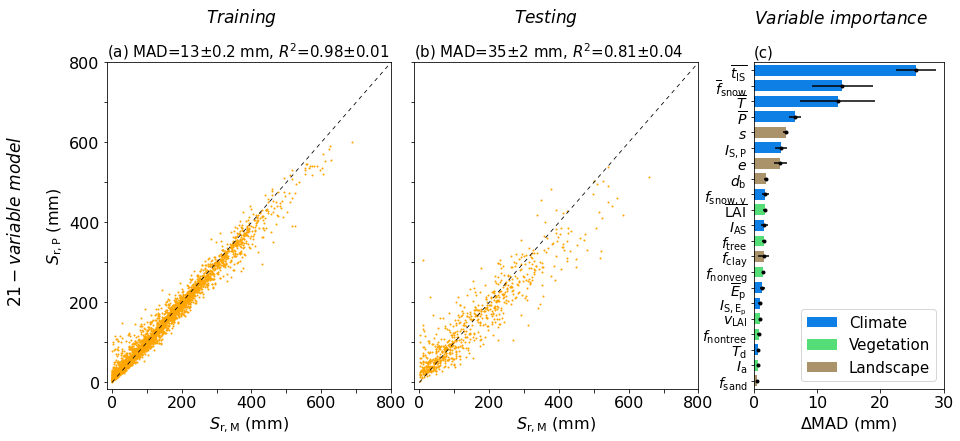

In [25]:
# scatter plots
x = np.linspace(0,800,100)
y = x
cmap_rdbu = cm.get_cmap('bwr_r', 4)
cmap_rdbu = ListedColormap([cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3)])
bounds = np.linspace(0, 4, 5)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

# color catchments in scatter plot based on error and use same colors on a map
df_train['group'] = np.nan
ix2 = df_train[(df_train['Sr_p-Sr_m']<train_mae)&(df_train['Sr_p-Sr_m']>0)].index
ix1 = df_train[(df_train['Sr_p-Sr_m']>train_mae)].index
ix3 = df_train[(df_train['Sr_p-Sr_m']>-train_mae)&(df_train['Sr_p-Sr_m']<0)].index
ix4 = df_train[(df_train['Sr_p-Sr_m']<-train_mae)].index
df_train.loc[ix1,'group'] = 0
df_train.loc[ix2,'group'] = 1
df_train.loc[ix3,'group'] = 2
df_train.loc[ix4,'group'] = 3

df_test['group'] = np.nan
ix2 = df_test[(df_test['Sr_p-Sr_m']<test_mae)&(df_test['Sr_p-Sr_m']>0)].index
ix1 = df_test[(df_test['Sr_p-Sr_m']>test_mae)].index
ix3 = df_test[(df_test['Sr_p-Sr_m']>-test_mae)&(df_test['Sr_p-Sr_m']<0)].index
ix4 = df_test[(df_test['Sr_p-Sr_m']<-test_mae)].index
df_test.loc[ix1,'group'] = 0
df_test.loc[ix2,'group'] = 1
df_test.loc[ix3,'group'] = 2
df_test.loc[ix4,'group'] = 3

fig1, ax = plt.subplots(1,4, figsize=(15,6),gridspec_kw={'width_ratios': [3,3,0.1,2]})
ax[2].axis('off')
plt.subplots_adjust(wspace=0.12)
s=ax[0].scatter(df_train.Sr_m,df_train.Sr_p,c='orange',s=1,cmap=cmap_rdbu,norm=norm,zorder=10)
ax[0].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[0].set_xlim(-15,800)
ax[0].set_ylim(-15,800)
ax[0].set_yticks([0,100,200,300,400,500,600,700,800])
ax[0].set_xticks([0,100,200,300,400,500,600,700,800])
ax[0].set_yticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xlabel('$S_\mathrm{r,M}$ (mm)',size=16)
ax[0].set_ylabel('$S_\mathrm{r,P}$ (mm)',size=16)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].set_title(f'(a) MAD={int(mae_train_mean)}$\pm${np.round(mae_train_std,1)} mm, $R^2$={np.round(r2_train_mean,2)}$\pm${np.round(r2_train_std,2)}', loc='left',size=15)
ax[0].text(270,900,'$\it{Training}$',size=17)
ax[0].text(-300,200,'$\it{21-variable}$ $\it{model}$',size=17,rotation=90)

s=ax[1].scatter(df_test.Sr_m,df_test.Sr_p,c='orange',s=1,cmap=cmap_rdbu,norm=norm,zorder=10)
ax[1].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[1].set_xlim(-15,800)
ax[1].set_ylim(-15,800)
ax[1].set_yticks([0,100,200,300,400,500,600,700,800])
ax[1].set_xticks([0,100,200,300,400,500,600,700,800])
ax[1].set_yticklabels(['','','','','','','','',''])
ax[1].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[1].set_xlabel('$S_\mathrm{r,M}$ (mm)',size=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_title(f'(b) MAD={int(mae_test_mean)}$\pm${int(np.round(mae_test_std,0))} mm, $R^2$={np.round(r2_test_mean,2)}$\pm${np.round(r2_test_std,2)}', loc='left',size=15)
ax[1].text(270,900,'$\it{Testing}$',size=17)

# feature importances
ddd = ddd.sort_values(by='mean')
ax[3].barh(ddd.features2,ddd['mean'],height=0.7,color=ddd.colors)
# ax[3].barh(ddd.index,ddd['mean'],height=0.7,color=ddd.colors)
ax[3].barh(0,-5,height=0.7,color=ddd.colors[2],label='Climate')
ax[3].barh(0,-5,height=0.7,color=ddd.colors[1],label='Vegetation')
ax[3].barh(0,-5,height=0.7,color=ddd.colors[0],label='Landscape')
ax[3].errorbar(ddd['mean'],ddd.features2, xerr=ddd['std'], fmt=".", color="black")
ax[3].set_xlabel('$\Delta$MAD (mm)',size=16)
ax[3].tick_params(axis='x', labelsize=16)
ax[3].tick_params(axis='y', labelsize=14)
ax[3].set_ylim(-0.5,20.5)
ax[3].set_xlim(0,30)
ax[3].set_title('(c)', loc='left',size=15)
ax[3].legend(loc='lower right',fontsize=15)
ax[3].text(0,23,'$\it{Variable}$ $\it{importance}$',size=17)

# fig1.savefig(f'{work_dir}/output/regression/figures/interpretation/scatter_{mod}.jpg',bbox_inches='tight',dpi=300)
fig1.savefig(f'{fig_dir}/scatter_{mod}.jpg',bbox_inches='tight',dpi=300)


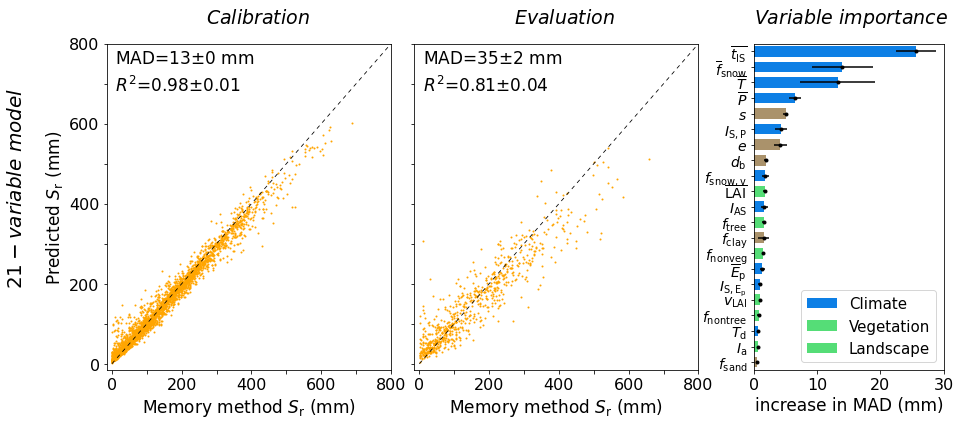

In [26]:
# scatter plots
x = np.linspace(0,800,100)
y = x
cmap_rdbu = cm.get_cmap('bwr_r', 4)
cmap_rdbu = ListedColormap([cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3)])
# cmap_rdbu = ListedColormap([cmap_rdbu(1),cmap_rdbu(0),cmap_rdbu(3),cmap_rdbu(2)])

bounds = np.linspace(0, 4, 5)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

# color catchments in scatter plot based on error and use same colors on a map
df_train['group'] = np.nan
ix2 = df_train[(df_train['Sr_p-Sr_m']<train_mae)&(df_train['Sr_p-Sr_m']>0)].index
ix1 = df_train[(df_train['Sr_p-Sr_m']>train_mae)].index
ix3 = df_train[(df_train['Sr_p-Sr_m']>-train_mae)&(df_train['Sr_p-Sr_m']<0)].index
ix4 = df_train[(df_train['Sr_p-Sr_m']<-train_mae)].index
df_train.loc[ix1,'group'] = 0
df_train.loc[ix2,'group'] = 1
df_train.loc[ix3,'group'] = 2
df_train.loc[ix4,'group'] = 3

df_test['group'] = np.nan
ix2 = df_test[(df_test['Sr_p-Sr_m']<test_mae)&(df_test['Sr_p-Sr_m']>0)].index
ix1 = df_test[(df_test['Sr_p-Sr_m']>test_mae)].index
ix3 = df_test[(df_test['Sr_p-Sr_m']>-test_mae)&(df_test['Sr_p-Sr_m']<0)].index
ix4 = df_test[(df_test['Sr_p-Sr_m']<-test_mae)].index
df_test.loc[ix1,'group'] = 0
df_test.loc[ix2,'group'] = 1
df_test.loc[ix3,'group'] = 2
df_test.loc[ix4,'group'] = 3

fig1, ax = plt.subplots(1,4, figsize=(15,6),gridspec_kw={'width_ratios': [3,3,0.1,2]})
ax[2].axis('off')
plt.subplots_adjust(wspace=0.12)
s=ax[0].scatter(df_train.Sr_m,df_train.Sr_p,c='orange',s=1,cmap=cmap_rdbu,norm=norm,zorder=10)
ax[0].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[0].set_xlim(-15,800)
ax[0].set_ylim(-15,800)
ax[0].set_yticks([0,100,200,300,400,500,600,700,800])
ax[0].set_xticks([0,100,200,300,400,500,600,700,800])
ax[0].set_yticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xlabel('Memory method $S_\mathrm{r}$ (mm)',size=17)
ax[0].set_ylabel('Predicted $S_\mathrm{r}$ (mm)',size=17)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].text(10,750,f'MAD={int(mae_train_mean)}$\pm${int(np.round(mae_train_std,0))} mm',size=17)
ax[0].text(10,680,f'$R^2$={np.round(r2_train_mean,2)}$\pm${np.round(r2_train_std,2)}',size=17)
# ax[0].set_title(f'(d) MAD={int(mae_train_mean)}$\pm${np.round(mae_train_std,1)} mm, $R^2$={np.round(r2_train_mean,2)}$\pm${np.round(r2_train_std,2)}', loc='left',size=15)
ax[0].text(270,850,'$\it{Calibration}$',size=19)
ax[0].text(-300,200,'$\it{21-variable}$ $\it{model}$',size=20,rotation=90)

s=ax[1].scatter(df_test.Sr_m,df_test.Sr_p,c='orange',s=1,cmap=cmap_rdbu,norm=norm,zorder=10)
ax[1].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[1].set_xlim(-15,800)
ax[1].set_ylim(-15,800)
ax[1].set_yticks([0,100,200,300,400,500,600,700,800])
ax[1].set_xticks([0,100,200,300,400,500,600,700,800])
ax[1].set_yticklabels(['','','','','','','','',''])
ax[1].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[1].set_xlabel('Memory method $S_\mathrm{r}$ (mm)',size=17)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].text(10,750,f'MAD={int(mae_test_mean)}$\pm${int(np.round(mae_test_std,0))} mm',size=17)
ax[1].text(10,680,f'$R^2$={np.round(r2_test_mean,2)}$\pm${np.round(r2_test_std,2)}',size=17)
# ax[1].set_title(f'(e) MAD={int(mae_test_mean)}$\pm${int(np.round(mae_test_std,0))} mm, $R^2$={np.round(r2_test_mean,2)}$\pm${np.round(r2_test_std,2)}', loc='left',size=15)
ax[1].text(270,850,'$\it{Evaluation}$',size=19)

# feature importances
ddd = ddd.sort_values(by='mean')
ax[3].barh(ddd.features2,ddd['mean'],height=0.7,color=ddd.colors)
ax[3].barh(0,-5,height=0.7,color=ddd.colors[2],label='Climate')
ax[3].barh(0,-5,height=0.7,color=ddd.colors[1],label='Vegetation')
ax[3].barh(0,-5,height=0.7,color=ddd.colors[4],label='Landscape')
ax[3].errorbar(ddd['mean'],ddd.features2, xerr=ddd['std'], fmt=".", color="black")
ax[3].set_xlabel('increase in MAD (mm)',size=17)
ax[3].tick_params(axis='x', labelsize=16)
ax[3].tick_params(axis='y', labelsize=14)
ax[3].set_ylim(-0.5,20.5)
ax[3].set_xlim(0,30)
# ax[3].set_title('(c)', loc='left',size=15)
ax[3].legend(loc='lower right',fontsize=15)
ax[3].text(0,21.8,'$\it{Variable}$ $\it{importance}$',size=19)

fig1.savefig(f'{fig_dir}/scatter_{mod}_presentation.jpg',bbox_inches='tight',dpi=300)


# MODEL B

In [8]:
mod = 'modelb'

In [9]:
#Europe
lat_min_e, lat_max_e = 35,75 # 36,46 only spain cluster
lon_min_e, lon_max_e = -12,29 # -10,5 only spain cluster

#Asia
lat_min_a, lat_max_a = 1,26
lon_min_a, lon_max_a = 68,105

#us
lat_min_u, lat_max_u = 12,65
lon_min_u, lon_max_u = -132,-52

#south america
lat_min_s, lat_max_s = -31,-3
lon_min_s, lon_max_s = -60,-32

#south africa
lat_min_f, lat_max_f = -35.3,-19.3
lon_min_f, lon_max_f = 12,36

#australia
lat_min_t, lat_max_t = -40,-25
lon_min_t, lon_max_t = 140,155

In [10]:
min_samples_leaf=1
max_depth=None

### cross validation

In [11]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
df['catch_id'] = df.index
features = ['idu_mean','t_mean','p_mean','slp_mean']
sr_rp = 'sr_20'
ll = ['lat','lon','catch_id']

f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

# here split dataset into 'temp' and 'test'
cv_outer = 5 # the number of outer cross validations
sdf = pd.DataFrame(index=range(cv_outer), columns=['n_estimators','max_depth','min_samples_leaf','max_features','train_mae','train_r2_adj','test_mae','test_r2_adj','train_r2','test_r2','n_train','n_test','fold'])
l = []
train_dfs=[]
test_dfs=[]

kf = KFold(n_splits=cv_outer,shuffle=True,random_state=0)
df = dfy.reshape(-1, 1).ravel()
i=0
cv_train_ix = []
cv_test_ix = []
ddl = []
for train_ix, test_ix in kf.split(dfx):
    cv_train_ix.append(train_ix)
    cv_test_ix.append(test_ix)
    X = dfx[train_ix]
    y = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix] 
    
    # save lat lon columns
    lat_train = X[:,-3]
    lon_train = X[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X[:,-1]
    catch_id_test = X_test[:,-1]

    # remove lat lon catchid columns
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)  
    
    # run rf model with full 'temp' set and test set using the best inner cross validation
    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf.fit(X,y)
    test_y_pred = rf.predict(X_test)
    train_y_pred = rf.predict(X)
    n_train,n_test = len(y),len(y_test)

    train_mae = np.round(mean_absolute_error(y, train_y_pred),2)
    train_r2_adj =  np.round(r2_adj(y, train_y_pred,features),2)
    train_r2 = np.round(r2_score(y, train_y_pred),2)
    
    test_mae = np.round(mean_absolute_error(y_test, test_y_pred),2)
    test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
    test_r2 = np.round(r2_score(y_test, test_y_pred),2)
    
    perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
    # perm_importance = permutation_importance(rf, X_train, y_test,scoring='neg_mean_absolute_error',random_state=42)
    pi = perm_importance.importances_mean
    dd = pd.DataFrame(index=features,columns=['pi'])
    dd.pi = pi
    ddl.append(dd)
    
    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y)/train_y_pred
    train_dfs.append(df_train)

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    test_dfs.append(df_test)

    # save scores in dataframe
    # sdf.loc[i][['n_estimators','max_depth','min_samples_leaf','max_features']] = [n_estimators,max_depth,min_samples_leaf,max_features]
    sdf.loc[i]['fold'] = i
    sdf.loc[i][['train_mae','train_r2_adj','train_r2']] = [train_mae,train_r2_adj,train_r2]
    sdf.loc[i][['test_mae','test_r2_adj','test_r2']] = [test_mae,test_r2_adj,test_r2]
    sdf.loc[i][['n_train','n_test']] = [n_train,n_test]
    print(i)
    i+=1

0
1
2
3
4


In [12]:
sdf

,n_estimators,max_depth,min_samples_leaf,max_features,train_mae,train_r2_adj,test_mae,test_r2_adj,train_r2,test_r2,n_train,n_test,fold
0,NaN,NaN,NaN,NaN,14.74,0.97,37.56,0.81,0.97,0.81,2889,723,0
1,NaN,NaN,NaN,NaN,14.34,0.97,41.35,0.72,0.97,0.72,2889,723,1
2,NaN,NaN,NaN,NaN,14.46,0.97,39.12,0.78,0.97,0.78,2890,722,2
3,NaN,NaN,NaN,NaN,14.62,0.97,38.65,0.78,0.97,0.78,2890,722,3
4,NaN,NaN,NaN,NaN,14.79,0.97,36.48,0.82,0.97,0.82,2890,722,4


In [13]:
# r squared
r2_train_mean = (sdf.train_r2.mean(axis=0))
r2_train_std = (sdf.train_r2.std(axis=0))
r2_test_mean = (sdf.test_r2.mean(axis=0))
r2_test_std = (sdf.test_r2.std(axis=0))
print(r2_train_mean, r2_train_std)
print(r2_test_mean, r2_test_std)

0.97 0.0
0.7819999999999999 0.03898717737923586


In [14]:
#adjusted r squared
r2_train_mean = (sdf.train_r2_adj.mean(axis=0))
r2_train_std = (sdf.train_r2_adj.std(axis=0))
r2_test_mean = (sdf.test_r2_adj.mean(axis=0))
r2_test_std = (sdf.test_r2_adj.std(axis=0))
print(r2_train_mean, r2_train_std)
print(r2_test_mean, r2_test_std)

0.97 0.0
0.7819999999999999 0.03898717737923586


In [15]:
mae_train_mean = (sdf.train_mae.mean(axis=0))
mae_train_std = (sdf.train_mae.std(axis=0))
mae_test_mean = (sdf.test_mae.mean(axis=0))
mae_test_std = (sdf.test_mae.std(axis=0))
print(mae_train_mean, mae_train_std)
print(mae_test_mean, mae_test_std)

14.589999999999998 0.18894443627691154
38.632 1.8307293628496824


In [16]:
len(df)

3612

In [17]:
# permutation importances for each cv fold
ddd = pd.DataFrame(index=ddl[0].index, columns=['pi0','pi1','pi2','pi3'])
ddd.pi0 = ddl[0].pi
ddd.pi1 = ddl[1].pi
ddd.pi2 = ddl[2].pi
ddd.pi3 = ddl[3].pi
ddd['mean'] = ddd.mean(axis=1)
ddd['std'] = ddd[['pi0','pi1','pi2','pi3']].std(axis=1)
ddd = ddd.sort_values(by='mean',ascending=False)
ddd['features2'] = ['$\overline{t_\mathrm{IS}}$','$\overline{T}$','$\overline{P}$','$s$']
rb = cm.get_cmap('terrain', 10)
c1,c2,c3 = rb(1),rb(3),rb(6)
ddd['colors'] = [c1,c1,c1,c3]
ddd

,pi0,pi1,pi2,pi3,mean,std,features2,colors
idu_mean,42.258868,45.257323,37.891021,43.581258,42.247118,3.152617,$\overline{t_\mathrm{IS}}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
t_mean,39.210363,36.121749,36.887359,34.647381,36.716713,1.904690,$\overline{T}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
p_mean,15.036016,17.945030,14.559422,20.617110,17.039395,2.815671,$\overline{P}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
slp_mean,16.213116,13.220095,14.314581,13.458328,14.301530,1.358286,$s$,"(0.6666666666666667, 0.5733333333333334, 0.420..."


In [18]:
# get mae for different regions
ll_e = lat_max_e, lat_min_e, lon_max_e, lon_min_e
ll_a = lat_max_a, lat_min_a, lon_max_a, lon_min_a
ll_u = lat_max_u, lat_min_u, lon_max_u, lon_min_u
ll_s = lat_max_s, lat_min_s, lon_max_s, lon_min_s
ll_f = lat_max_f, lat_min_f, lon_max_f, lon_min_f
ll_t = lat_max_t, lat_min_t, lon_max_t, lon_min_t
ll = [ll_e,ll_a,ll_u,ll_s,ll_f,ll_t]

dfr = pd.DataFrame(index=[0,1,2,3,4], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = train_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['Sr_p-Sr_m']).mean()
        dfr.iloc[i,j] = mae
dfrr = pd.DataFrame(index=['mean','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
dfrr.loc['mean',:] = np.round(dfr.mean(axis=0),0)
dfrr.loc['median',:] = np.round(dfr.mean(axis=0),0)
dfrr.loc['std',:] = np.round(dfr.std(axis=0),0)

dfr = pd.DataFrame(index=[0,1,2,3,4], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = test_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['Sr_p-Sr_m']).mean()
        dfr.iloc[i,j] = mae
dfrrt = pd.DataFrame(index=['mean','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
dfrrt.loc['mean',:] = np.round(dfr.mean(axis=0),0)
dfrrt.loc['median',:] = np.round(dfr.mean(axis=0),0)
dfrrt.loc['std',:] = np.round(dfr.std(axis=0),0)

# relative
dfr = pd.DataFrame(index=[0,1,2,3,4], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = train_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['(Sr_p-Sr_m)/Sr_m']).mean()
        dfr.iloc[i,j] = mae
dfrr_rel = pd.DataFrame(index=['mean','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
dfrr_rel.loc['mean',:] = np.round(dfr.mean(axis=0),2)
dfrr_rel.loc['median',:] = np.round(dfr.median(axis=0),2)
dfrr_rel.loc['std',:] = np.round(dfr.std(axis=0),2)

dfr = pd.DataFrame(index=[0,1,2,3,4], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = test_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['(Sr_p-Sr_m)/Sr_m']).mean()
        dfr.iloc[i,j] = mae
dfrrt_rel = pd.DataFrame(index=['mean','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
dfrrt_rel.loc['mean',:] = np.round(dfr.mean(axis=0),2)
dfrrt_rel.loc['median',:] = np.round(dfr.median(axis=0),2)
dfrrt_rel.loc['std',:] = np.round(dfr.std(axis=0),2)

In [19]:
#test
dfrrt

,mad_europe,mad_asia,mad_northamerica,mad_southamerica,mad_southafrica,mad_australia
mean,37.0,83.0,29.0,43.0,45.0,52.0
std,2.0,13.0,2.0,1.0,12.0,11.0
median,37.0,83.0,29.0,43.0,45.0,52.0


In [20]:
#test rel
dfrrt_rel = dfrrt_rel*100
dfrrt_rel

,mad_europe,mad_asia,mad_northamerica,mad_southamerica,mad_southafrica,mad_australia
mean,43.0,28.0,34.0,26.0,25.0,35.0
std,2.0,4.0,2.0,2.0,9.0,9.0
median,43.0,27.0,34.0,26.0,23.0,34.0


In [21]:
# get mae for different regions
ll_e = lat_max_e, lat_min_e, lon_max_e, lon_min_e
ll_a = lat_max_a, lat_min_a, lon_max_a, lon_min_a
ll_u = lat_max_u, lat_min_u, lon_max_u, lon_min_u
ll_s = lat_max_s, lat_min_s, lon_max_s, lon_min_s
ll_f = lat_max_f, lat_min_f, lon_max_f, lon_min_f
ll_t = lat_max_t, lat_min_t, lon_max_t, lon_min_t
ll = [ll_e,ll_a,ll_u,ll_s,ll_f,ll_t]

dfr = pd.DataFrame(index=[0,1,2,3,4], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = train_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['Sr_p-Sr_m']).median()
        dfr.iloc[i,j] = mae
mdfrr = pd.DataFrame(index=['median','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
mdfrr.loc['median',:] = np.round(dfr.median(axis=0),0)
mdfrr.loc['median',:] = np.round(dfr.median(axis=0),0)
mdfrr.loc['std',:] = np.round(dfr.std(axis=0),0)

dfr = pd.DataFrame(index=[0,1,2,3,4], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = test_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['Sr_p-Sr_m']).median()
        dfr.iloc[i,j] = mae
mdfrrt = pd.DataFrame(index=['median','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
mdfrrt.loc['median',:] = np.round(dfr.median(axis=0),0)
mdfrrt.loc['median',:] = np.round(dfr.median(axis=0),0)
mdfrrt.loc['std',:] = np.round(dfr.std(axis=0),0)

# relative
dfr = pd.DataFrame(index=[0,1,2,3,4], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = train_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['(Sr_p-Sr_m)/Sr_m']).median()
        dfr.iloc[i,j] = mae
mdfrr_rel = pd.DataFrame(index=['median','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
mdfrr_rel.loc['median',:] = np.round(dfr.median(axis=0),2)
mdfrr_rel.loc['median',:] = np.round(dfr.median(axis=0),2)
mdfrr_rel.loc['std',:] = np.round(dfr.std(axis=0),2)

dfr = pd.DataFrame(index=[0,1,2,3,4], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = test_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['(Sr_p-Sr_m)/Sr_m']).median()
        dfr.iloc[i,j] = mae
mdfrrt_rel = pd.DataFrame(index=['median','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
mdfrrt_rel.loc['median',:] = np.round(dfr.median(axis=0),2)
mdfrrt_rel.loc['median',:] = np.round(dfr.median(axis=0),2)
mdfrrt_rel.loc['std',:] = np.round(dfr.std(axis=0),2)

In [22]:
#test
mdfrrt

,mad_europe,mad_asia,mad_northamerica,mad_southamerica,mad_southafrica,mad_australia
median,27.0,65.0,20.0,30.0,33.0,39.0
std,2.0,20.0,1.0,3.0,12.0,10.0


In [23]:
#test rel
mdfrrt_rel = mdfrrt_rel*100
mdfrrt_rel

,mad_europe,mad_asia,mad_northamerica,mad_southamerica,mad_southafrica,mad_australia
median,35.0,23.0,22.0,17.0,16.0,21.0
std,4.0,4.0,3.0,2.0,8.0,5.0


In [24]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
features = ['idu_mean','t_mean','p_mean','slp_mean']

In [25]:
df

,p_mean,ep_mean,t_mean,tdiff_mean,idu_mean,si_ep,si_p,asi,dtb,ia,...,nonveg,pclay,psand,lai_mean,lai_rsd,sc_mean,sc_rsd,sr_20,lat,lon
ca_0002351,1.590253,1.401269,0.643260,25.221876,5.05,0.704030,0.464383,0.000000,19.41,0.003286,...,0.294740,17.094944,45.838508,0.950806,0.641162,41.416667,0.833385,86.691569,51.01460,-114.08960
cz_0000019,2.285853,1.484881,7.528472,22.165638,3.81,0.554593,0.213216,0.024284,18.85,0.000002,...,0.180999,16.322265,42.762079,1.885474,0.753561,25.416667,1.311083,51.681945,49.76040,16.97290
br_0001191,4.152597,3.260944,24.602384,4.562576,2.67,0.138040,0.173603,0.121069,25.74,0.003675,...,0.073967,36.166791,44.203801,2.808409,0.113255,0.000000,0.000000,173.824040,-13.36460,-39.08130
br_0000469,4.944120,3.258352,26.827793,2.495693,6.62,0.049197,0.609147,0.114847,25.93,0.000325,...,0.248321,28.315328,54.128498,1.862262,0.252759,0.000000,0.000000,333.062414,-6.67290,-48.46880
bw_0000006,1.358820,2.669859,20.623299,10.890681,12.46,0.245236,0.838107,0.037922,10.34,0.000000,...,0.241470,21.254629,69.722858,0.581395,0.657466,0.000000,0.000000,221.777925,-21.08960,27.51460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342933,3.745021,2.813956,18.574819,20.548962,4.03,0.321256,0.142954,0.115187,13.33,0.002393,...,0.112886,26.071614,49.831392,2.687272,0.570877,0.083333,3.464102,264.588102,32.01766,-85.29577
8155200,2.443305,2.539987,19.716896,20.792007,5.18,0.401462,0.217222,0.057260,8.45,0.000323,...,0.154220,32.240327,38.662520,1.062247,0.224592,0.000000,0.000000,295.776515,30.29632,-97.92557
2472000,4.120200,2.897947,18.336339,20.451761,3.89,0.320265,0.123824,0.156997,18.81,0.000853,...,0.140715,28.204969,32.187203,2.862665,0.514875,0.000000,0.000000,236.554537,31.70694,-89.40694
6784000,1.772299,1.731829,9.414148,29.647746,4.86,0.627384,0.512336,0.000000,140.87,0.235538,...,0.276233,18.066044,51.319892,0.738392,0.884287,9.000000,1.464890,190.322812,41.03244,-98.74053


In [26]:
sr_rp = 'sr_20'
df['catch_id'] = df.index
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

train_ix = cv_train_ix[1]
test_ix = cv_test_ix[1]

X_train = dfx[train_ix]
y_train = dfy[train_ix]
X_test = dfx[test_ix]
y_test = dfy[test_ix]

# save lat lon columns
lat_train = X_train[:,-3]
lon_train = X_train[:,-2]
lat_test = X_test[:,-3]
lon_test = X_test[:,-2]
catch_id_train = X_train[:,-1]
catch_id_test = X_test[:,-1]
# remove lat lon columns
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)

rf = RandomForestRegressor(criterion='absolute_error',random_state=42,max_depth=max_depth,min_samples_leaf=min_samples_leaf,oob_score=True)
rf = rf.fit(X_train, y_train)
train_y_pred = rf.predict(X_train)
test_y_pred = rf.predict(X_test)
individual_tree_predictions = np.array([tree.predict(X_test) for tree in rf.estimators_]).T
std_test = np.std(individual_tree_predictions,axis=1)
individual_tree_predictions = np.array([tree.predict(X_train) for tree in rf.estimators_]).T
std_train = np.std(individual_tree_predictions,axis=1)

df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m','std_train'])
df_train['lat'] = lat_train
df_train['lon'] = lon_train
df_train['Sr_m'] = y_train
df_train['Sr_p'] = train_y_pred
df_train['Sr_p-Sr_m'] = train_y_pred - y_train
df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred
df_train['std'] = std_train

df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m','std_test'])
df_test['lat'] = lat_test
df_test['lon'] = lon_test
df_test['Sr_m'] = y_test
df_test['Sr_p'] = test_y_pred
df_test['Sr_p-Sr_m'] = test_y_pred - y_test
df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
df_test['std'] = std_test

train_mse = int(mean_squared_error(y_train, train_y_pred))
train_mae = int(np.round(mean_absolute_error(y_train, train_y_pred),0))
train_r2 = np.round(r2_score(y_train, train_y_pred),2)
train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
train_rmse = int(rmse(y_train,train_y_pred))
train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)

test_mse = int(mean_squared_error(y_test, test_y_pred))
test_mae = int(np.round(mean_absolute_error(y_test, test_y_pred),0))
test_r2 = np.round(r2_score(y_test, test_y_pred),2)
test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
test_rmse = int(rmse(y_test,test_y_pred))
test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)

n_test = len(y_test)
n_train = len(y_train)

perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
dd = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
dd['pi_mean'] = pi
dd['pi_std'] = perm_importance.importances_std
dd = dd.sort_values(by='pi_mean') 

perm_importance = permutation_importance(rf, X_train, y_train,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
ddtr = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
ddtr['pi_mean'] = pi
ddtr['pi_std'] = perm_importance.importances_std
ddtr = ddtr.sort_values(by='pi_mean')    

sdf = pd.DataFrame(index=[0])
sdf[features] = np.round(pi,4)
sdf[['train_mse','train_rmse','train_mae','train_r2','train_r2_adj','train_mape']] = [train_mse,train_rmse,train_mae,train_r2,train_r2_adj,train_mape]
sdf[['test_mse','test_rmse','test_mae','test_r2','test_r2_adj','test_mape']] = [test_mse,test_rmse,test_mae,test_r2,test_r2_adj,test_mape]
sdf[['n_train','n_test']] = [n_train,n_test]


In [27]:
df_test

,lat,lon,Sr_m,Sr_p,Sr_p-Sr_m,(Sr_p-Sr_m)/Sr_m,std_test,std
br_0001191,-13.3646,-39.0813,173.824040,173.211761,-0.612279,-0.003535,NaN,83.321696
ca_0005679,49.0937,-120.6729,108.511781,91.474556,-17.037225,-0.186251,NaN,70.325167
us_0002162,32.9771,-85.7396,186.107329,191.912494,5.805165,0.030249,NaN,31.306571
fr_0000453,45.2646,1.3771,130.998251,129.571450,-1.426801,-0.011012,NaN,75.012951
ca_0004570,51.1396,-120.1187,26.879852,39.119919,12.240068,0.312886,NaN,37.678715
...,...,...,...,...,...,...,...,...
3182500,38.18595,-80.13062,38.715440,53.631051,14.915611,0.278115,NaN,31.814185
8101000,31.28489,-97.88502,325.049120,318.160812,-6.888308,-0.021650,NaN,51.618160
7180500,38.19645,-96.82458,202.793262,225.190313,22.397052,0.099458,NaN,82.616599
9497980,33.82783,-110.85623,213.232311,197.104875,-16.127436,-0.081822,NaN,68.042517


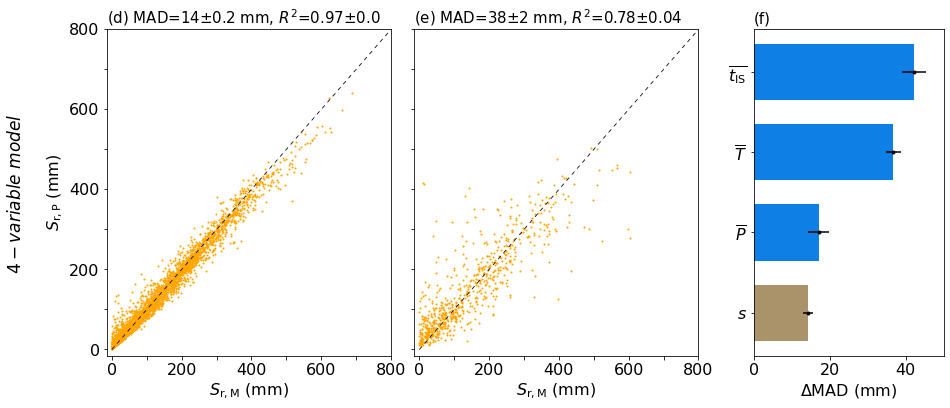

In [28]:
# scatter plots
x = np.linspace(0,800,100)
y = x
cmap_rdbu = cm.get_cmap('bwr_r', 4)
cmap_rdbu = ListedColormap([cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3)])

bounds = np.linspace(0, 4, 5)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

# color catchments in scatter plot based on error and use same colors on a map
df_train['group'] = np.nan
ix2 = df_train[(df_train['Sr_p-Sr_m']<train_mae)&(df_train['Sr_p-Sr_m']>0)].index
ix1 = df_train[(df_train['Sr_p-Sr_m']>train_mae)].index
ix3 = df_train[(df_train['Sr_p-Sr_m']>-train_mae)&(df_train['Sr_p-Sr_m']<0)].index
ix4 = df_train[(df_train['Sr_p-Sr_m']<-train_mae)].index
df_train.loc[ix1,'group'] = 0
df_train.loc[ix2,'group'] = 1
df_train.loc[ix3,'group'] = 2
df_train.loc[ix4,'group'] = 3

df_test['group'] = np.nan
ix2 = df_test[(df_test['Sr_p-Sr_m']<test_mae)&(df_test['Sr_p-Sr_m']>0)].index
ix1 = df_test[(df_test['Sr_p-Sr_m']>test_mae)].index
ix3 = df_test[(df_test['Sr_p-Sr_m']>-test_mae)&(df_test['Sr_p-Sr_m']<0)].index
ix4 = df_test[(df_test['Sr_p-Sr_m']<-test_mae)].index
df_test.loc[ix1,'group'] = 0
df_test.loc[ix2,'group'] = 1
df_test.loc[ix3,'group'] = 2
df_test.loc[ix4,'group'] = 3

fig1, ax = plt.subplots(1,4, figsize=(15,6),gridspec_kw={'width_ratios': [3,3,0.1,2]})
ax[2].axis('off')
plt.subplots_adjust(wspace=0.12)
s=ax[0].scatter(df_train.Sr_m,df_train.Sr_p,c='orange',s=1,cmap=cmap_rdbu,norm=norm,zorder=10)
ax[0].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[0].set_xlim(-15,800)
ax[0].set_ylim(-15,800)
ax[0].set_yticks([0,100,200,300,400,500,600,700,800])
ax[0].set_xticks([0,100,200,300,400,500,600,700,800])
ax[0].set_yticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xlabel('$S_\mathrm{r,M}$ (mm)',size=16)
ax[0].set_ylabel('$S_\mathrm{r,P}$ (mm)',size=16)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].set_title(f'(d) MAD={int(mae_train_mean)}$\pm${np.round(mae_train_std,1)} mm, $R^2$={np.round(r2_train_mean,2)}$\pm${np.round(r2_train_std,2)}', loc='left',size=15)
ax[0].text(-300,200,'$\it{4-variable}$ $\it{model}$',size=17,rotation=90)

s=ax[1].scatter(df_test.Sr_m,df_test.Sr_p,c='orange',s=1,cmap=cmap_rdbu,norm=norm,zorder=10)
ax[1].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[1].set_xlim(-15,800)
ax[1].set_ylim(-15,800)
ax[1].set_yticks([0,100,200,300,400,500,600,700,800])
ax[1].set_xticks([0,100,200,300,400,500,600,700,800])
ax[1].set_yticklabels(['','','','','','','','',''])
ax[1].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[1].set_xlabel('$S_\mathrm{r,M}$ (mm)',size=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_title(f'(e) MAD={int(mae_test_mean)}$\pm${int(np.round(mae_test_std,0))} mm, $R^2$={np.round(r2_test_mean,2)}$\pm${np.round(r2_test_std,2)}', loc='left',size=15)

# feature importances
rb = cm.get_cmap('terrain', 10)
c1,c2,c3 = rb(1),rb(3),rb(6)
ddd = ddd.sort_values(by='mean')
ax[3].barh(ddd.features2,ddd['mean'],height=0.7,color=ddd['colors'])
ax[3].errorbar(ddd['mean'],ddd.features2, xerr=ddd['std'], fmt=".", color="black")
ax[3].set_xlabel('$\Delta$MAD (mm)',size=16)
ax[3].tick_params(axis='x', labelsize=16)
ax[3].tick_params(axis='y', labelsize=16)
# ax[3].set_ylim(-0.5,20.5)
ax[3].set_xlim(0,50)
ax[3].set_title('(f)', loc='left',size=15)
fig1.savefig(f'{fig_dir}/scatter_{mod}.jpg',bbox_inches='tight',dpi=300)


In [29]:
# combine all cv's train and test results
test_dfs=[]
train_dfs=[]
for i in range(5):
    train_ix = cv_train_ix[i]
    test_ix = cv_test_ix[i]

    X_train = dfx[train_ix]
    y_train = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix]

    # save lat lon columns
    lat_train = X_train[:,-3]
    lon_train = X_train[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X_train[:,-1]
    catch_id_test = X_test[:,-1]
    # remove lat lon columns
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)

    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf = rf.fit(X_train, y_train)
    train_y_pred = rf.predict(X_train)
    test_y_pred = rf.predict(X_test)
    individual_tree_predictions = np.array([tree.predict(X_test) for tree in rf.estimators_]).T
    std_test = np.std(individual_tree_predictions,axis=1)
    individual_tree_predictions = np.array([tree.predict(X_train) for tree in rf.estimators_]).T
    std_train = np.std(individual_tree_predictions,axis=1)

    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m','std'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y_train
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y_train
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred
    df_train['std'] = std_train
    train_dfs.append(df_train)

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m','std'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    df_test['std'] = std_test
    test_dfs.append(df_test)

test_dfs = pd.concat(test_dfs)
train_dfs = pd.concat(train_dfs)

# color catchments in scatter plot based on error and use same colors on a map
train_dfs['group'] = np.nan
ix2 = train_dfs[(train_dfs['Sr_p-Sr_m']<mae_train_mean)&(train_dfs['Sr_p-Sr_m']>0)].index
ix1 = train_dfs[(train_dfs['Sr_p-Sr_m']>mae_train_mean)].index
ix3 = train_dfs[(train_dfs['Sr_p-Sr_m']>-mae_train_mean)&(train_dfs['Sr_p-Sr_m']<0)].index
ix4 = train_dfs[(train_dfs['Sr_p-Sr_m']<-mae_train_mean)].index
train_dfs.loc[ix1,'group'] = 0
train_dfs.loc[ix2,'group'] = 1
train_dfs.loc[ix3,'group'] = 2
train_dfs.loc[ix4,'group'] = 3

test_dfs['group'] = np.nan
ix2 = test_dfs[(test_dfs['Sr_p-Sr_m']<mae_test_mean)&(test_dfs['Sr_p-Sr_m']>0)].index
ix1 = test_dfs[(test_dfs['Sr_p-Sr_m']>mae_test_mean)].index
ix3 = test_dfs[(test_dfs['Sr_p-Sr_m']>-mae_test_mean)&(test_dfs['Sr_p-Sr_m']<0)].index
ix4 = test_dfs[(test_dfs['Sr_p-Sr_m']<-mae_test_mean)].index
test_dfs.loc[ix1,'group'] = 0
test_dfs.loc[ix2,'group'] = 1
test_dfs.loc[ix3,'group'] = 2
test_dfs.loc[ix4,'group'] = 3

test_dfs.to_csv(f'{work_dir}/output/regression/rf_results_{mod}_combined_test.csv')

In [30]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [31]:
#Europe
lat_min_e, lat_max_e = 35,62 # 36,46 only spain cluster
lon_min_e, lon_max_e = -12,29 # -10,5 only spain cluster

#Asia
lat_min_a, lat_max_a = 1,26
lon_min_a, lon_max_a = 68,105

#us
lat_min_u, lat_max_u = 12,65
lon_min_u, lon_max_u = -132,-52

#south america
lat_min_s, lat_max_s = -31,-3
lon_min_s, lon_max_s = -60,-32

#south africa
lat_min_f, lat_max_f = -35.3,-19.3
lon_min_f, lon_max_f = 12,36

#australia
lat_min_t, lat_max_t = -40,-25
lon_min_t, lon_max_t = 140,155

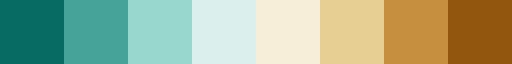

In [43]:
import matplotlib
cmap = cm.get_cmap('BrBG_r', 10)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmap_rdbu = ListedColormap(color_list[1:-1])
cmap_rdbu.set_over(color_list[-1])
cmap_rdbu.set_under(color_list[0])
cmap_rdbu

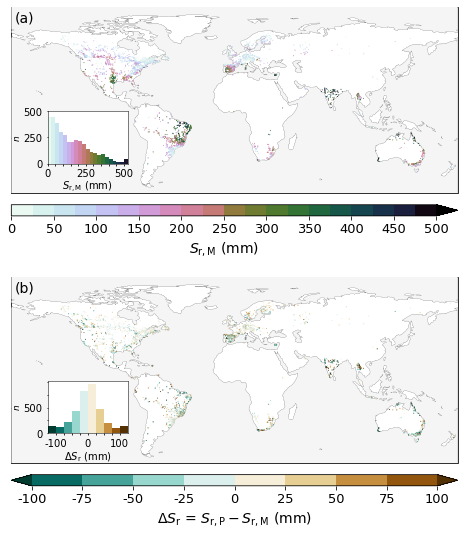

In [44]:
# sr memory method maps
cmap_rdbu1 = cmap_sr
bounds = np.linspace(0,500,21)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

fig2 = plt.figure(figsize=(8,16))
ax = fig2.add_subplot(211,projection=ccrs.PlateCarree())
plt.subplots_adjust(hspace=-0.55)

ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(test_dfs.lon,test_dfs.lat,s=0.7,c=test_dfs['Sr_m'],edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_sr,norm=norm,zorder=102)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=40,norm=norm)
cbar.set_label('$S_\mathrm{r,M}$ (mm)',size=14)
cbar.set_ticks(bounds2)
cbar.set_ticklabels(['0','50','100','150','200','250','300','350','400','450','500'],size=13)
ax.text(-177,78,'(a)',size=14,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
n=[]
for i in range(len(bounds)):
    if (i<len(bounds)-1):
        nn = len(test_dfs[(test_dfs['Sr_m']<bounds[i+1])&(test_dfs['Sr_m']>=bounds[i])])
    else:
        nn=len(test_dfs[(test_dfs['Sr_m']>=bounds[i])])
    n.append(nn)
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],n,width=1,
        color=[cmap_rdbu1(0),cmap_rdbu1(1),cmap_rdbu1(2),cmap_rdbu1(3),cmap_rdbu1(4),cmap_rdbu1(5),cmap_rdbu1(6),cmap_rdbu1(7),cmap_rdbu1(8),cmap_rdbu1(9),cmap_rdbu1(10),
              cmap_rdbu1(11),cmap_rdbu1(12),cmap_rdbu1(13),cmap_rdbu1(14),cmap_rdbu1(15),cmap_rdbu1(16),cmap_rdbu1(17),cmap_rdbu1(18),cmap_rdbu1(19),cmap_rdbu1(20)])
iax.set_xticks(np.arange(-0.5,20,2))
iax.set_xticklabels(['0','','','','','250','','','','','500'])
iax.set_xlim(-0.5,20.5)
iax.set_yticks([0,250,500])
iax.set_yticklabels(['0','250','500'])
iax.set_xlabel('$S_\mathrm{r,M}$ (mm)',size=10,labelpad=1)
iax.set_ylabel('$n$',size=9,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=10)


# all test results from cross validation on map - ABSDIFF
cmap_rdbu1 = cm.get_cmap('BrBG_r',10)
bounds = np.linspace(-100,100,9)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

x=test_dfs['lat'].astype(float)
y=test_dfs['lon'].astype(float)
kde = gaussian_kde(np.vstack([x, y]))
density1 = kde(np.vstack([x, y]))*1000
density2 = (np.clip(density1, 0.06, 0.23))
test_dfs['density'] = 1/(density2*10)

ax = fig2.add_subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(test_dfs.lon,test_dfs.lat,s=0.5*test_dfs['density'],c=test_dfs['Sr_p-Sr_m'],edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=105)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='both', pad=0.02,aspect=40,norm=norm)
cbar.set_label('$\Delta$$S_\mathrm{r}$ = $S_\mathrm{r,P}-S_\mathrm{r,M}$ (mm)',size=14)
cbar.set_ticklabels(['-100','-75','-50','-25','0','25','50','75','100'],size=13)
ax.text(-177,78,'(b)',size=14,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
n0=len(test_dfs[test_dfs['Sr_p-Sr_m']<bounds[0]])
n1=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[1])&(test_dfs['Sr_p-Sr_m']>bounds[0])])
n2=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[2])&(test_dfs['Sr_p-Sr_m']>bounds[1])])
n3=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[3])&(test_dfs['Sr_p-Sr_m']>bounds[2])])
n4=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[4])&(test_dfs['Sr_p-Sr_m']>bounds[3])])
n5=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[5])&(test_dfs['Sr_p-Sr_m']>bounds[4])])
n6=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[6])&(test_dfs['Sr_p-Sr_m']>bounds[5])])
n7=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[7])&(test_dfs['Sr_p-Sr_m']>bounds[6])])
n8=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[8])&(test_dfs['Sr_p-Sr_m']>bounds[7])])
n9=len(test_dfs[(test_dfs['Sr_p-Sr_m']>bounds[8])])
n = [n0,n1,n2,n3,n4,n5,n6,n7,n8,n9]
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar([0,1,2,3,4,5,6,7,8,9],n,width=1,color=[cmap_rdbu1(0),cmap_rdbu1(1),cmap_rdbu1(2),cmap_rdbu1(3),cmap_rdbu1(4),cmap_rdbu1(5),cmap_rdbu1(6),cmap_rdbu1(7),cmap_rdbu1(8),cmap_rdbu1(9)])
iax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])
iax.set_yticks([0,250,500,750,1000])
iax.set_yticklabels(['0','','500','',''])
iax.set_xticklabels(['-100','','','','0','','','','100'])
iax.set_xlim(-0.5,9.5)
iax.set_xlabel('$\Delta$$S_\mathrm{r}$ (mm)',size=10, labelpad=1)
iax.set_ylabel('$n$',size=9,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=10)
fig2.savefig(f'{fig_dir}/fig01.jpg',bbox_inches='tight',dpi=900)


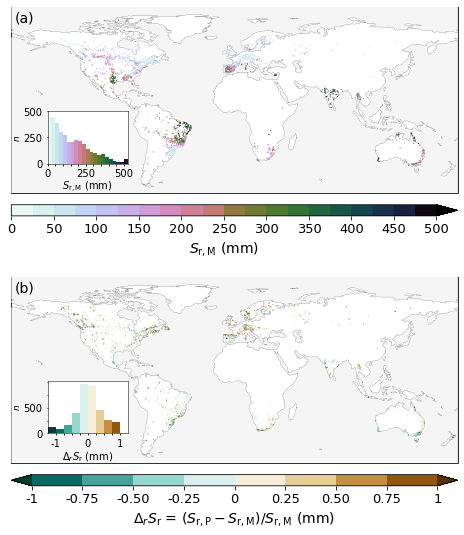

In [45]:
# sr memory method maps
cmap_rdbu1 = cmap_sr
bounds = np.linspace(0,500,21)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

fig2 = plt.figure(figsize=(8,16))
ax = fig2.add_subplot(211,projection=ccrs.PlateCarree())
plt.subplots_adjust(hspace=-0.55)

ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(test_dfs.lon,test_dfs.lat,s=0.7,c=test_dfs['Sr_m'],edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_sr,norm=norm,zorder=102)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=40,norm=norm)
cbar.set_label('$S_\mathrm{r,M}$ (mm)',size=14)
cbar.set_ticks(bounds2)
cbar.set_ticklabels(['0','50','100','150','200','250','300','350','400','450','500'],size=13)
ax.text(-177,78,'(a)',size=14,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
n=[]
for i in range(len(bounds)):
    if (i<len(bounds)-1):
        nn = len(test_dfs[(test_dfs['Sr_m']<bounds[i+1])&(test_dfs['Sr_m']>=bounds[i])])
    else:
        nn=len(test_dfs[(test_dfs['Sr_m']>=bounds[i])])
    n.append(nn)
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],n,width=1,
        color=[cmap_rdbu1(0),cmap_rdbu1(1),cmap_rdbu1(2),cmap_rdbu1(3),cmap_rdbu1(4),cmap_rdbu1(5),cmap_rdbu1(6),cmap_rdbu1(7),cmap_rdbu1(8),cmap_rdbu1(9),cmap_rdbu1(10),
              cmap_rdbu1(11),cmap_rdbu1(12),cmap_rdbu1(13),cmap_rdbu1(14),cmap_rdbu1(15),cmap_rdbu1(16),cmap_rdbu1(17),cmap_rdbu1(18),cmap_rdbu1(19),cmap_rdbu1(20)])
iax.set_xticks(np.arange(-0.5,20,2))
iax.set_xticklabels(['0','','','','','250','','','','','500'])
iax.set_xlim(-0.5,20.5)
iax.set_yticks([0,250,500])
iax.set_yticklabels(['0','250','500'])
iax.set_xlabel('$S_\mathrm{r,M}$ (mm)',size=10,labelpad=1)
iax.set_ylabel('$n$',size=9,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=10)


# all test results from cross validation on map - REL
cmap_rdbu1 = cm.get_cmap('BrBG_r',10)
bounds = np.linspace(-1,1,9)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

x=test_dfs['lat'].astype(float)
y=test_dfs['lon'].astype(float)
kde = gaussian_kde(np.vstack([x, y]))
density1 = kde(np.vstack([x, y]))*1000
density2 = (np.clip(density1, 0.06, 0.23))
test_dfs['density'] = 1/(density2*10)

ax = fig2.add_subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(test_dfs.lon,test_dfs.lat,s=0.5*test_dfs['density'],c=test_dfs['(Sr_p-Sr_m)/Sr_m'],edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=105)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='both', pad=0.02,aspect=40,norm=norm)
cbar.set_label('$\Delta_r$$S_\mathrm{r}$ = ($S_\mathrm{r,P}-S_\mathrm{r,M})/S_\mathrm{r,M}$ (mm)',size=14)
cbar.set_ticklabels(['-1','-0.75','-0.50','-0.25','0','0.25','0.50','0.75','1'],size=13)
ax.text(-177,78,'(b)',size=14,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
n0=len(test_dfs[test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[0]])
n1=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[1])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[0])])
n2=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[2])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[1])])
n3=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[3])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[2])])
n4=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[4])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[3])])
n5=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[5])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[4])])
n6=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[6])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[5])])
n7=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[7])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[6])])
n8=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[8])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[7])])
n9=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[8])])
n = [n0,n1,n2,n3,n4,n5,n6,n7,n8,n9]
n = [n0,n1,n2,n3,n4,n5,n6,n7,n8,n9]
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar([0,1,2,3,4,5,6,7,8,9],n,width=1,color=[cmap_rdbu1(0),cmap_rdbu1(1),cmap_rdbu1(2),cmap_rdbu1(3),cmap_rdbu1(4),cmap_rdbu1(5),cmap_rdbu1(6),cmap_rdbu1(7),cmap_rdbu1(8),cmap_rdbu1(9)])
iax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])
iax.set_yticks([0,250,500,750,1000])
iax.set_yticklabels(['0','','500','',''])
iax.set_xticklabels(['-1','','','','0','','','','1'])
iax.set_xlim(-0.5,9.5)
iax.set_xlabel('$\Delta_r$$S_\mathrm{r}$ (mm)',size=10, labelpad=1)
iax.set_ylabel('$n$',size=9,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=10)

fig2.savefig(f'{fig_dir}/reldiff_maps.jpg',bbox_inches='tight',dpi=900)


In [46]:
a = len(test_dfs[abs(test_dfs['Sr_p-Sr_m']<50)])
print('the number of catchments within +/- 50 mm error:', a)
print('the % of catchments within +/- 50 mm error:', a/len(test_dfs) * 100)

the number of catchments within +/- 50 mm error: 3173
the % of catchments within +/- 50 mm error: 87.84606866002214


## ICE plots - test results 5 cvs

In [47]:
# combine all cv's train and test results
grid_resolution=100
ps = []
ics = []
for i in range(5):
    train_ix = cv_train_ix[i]
    test_ix = cv_test_ix[i]

    X_train = dfx[train_ix]
    y_train = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix]

    # save lat lon columns
    lat_train = X_train[:,-3]
    lon_train = X_train[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X_train[:,-1]
    catch_id_test = X_test[:,-1]
    # remove lat lon columns
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)

    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf = rf.fit(X_train, y_train)
    train_y_pred = rf.predict(X_train)
    test_y_pred = rf.predict(X_test)
    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y_train
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y_train
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    
    pdps=[]
    ices=[]
    for k in range(len(features)):
        a = partial_dependence(rf, features=[k], X=X_test, percentiles=(0, 1),grid_resolution=grid_resolution, kind='both')
        if(k==0):
            a = partial_dependence(rf, features=[k], X=X_test, percentiles=(0, 1),grid_resolution=1000, kind='both') # higher grid resolution for idu mean
        pdpp = pd.DataFrame(index=['average'],data=a['average'],columns=a['values'][0])
        ice = pd.DataFrame(index=df_test.index, data=a['individual'][0],columns=a['values'][0])
        pdp = pd.concat([pdpp])
        pdps.append(pdp)
        ices.append(ice)
    ps.append(pdps)
    ics.append(ices)

In [48]:
# interpolate so we get same x axis for all cross validation folds
icsi=[]
for k in range(len(features)):
    ice0 = ics[0][k]
    ice1 = ics[1][k]
    ice2 = ics[2][k]
    ice3 = ics[3][k]
    ice4 = ics[4][k]
    
    x0 = ice0.columns.values
    x1 = ice1.columns.values
    x2 = ice2.columns.values
    x3 = ice3.columns.values
    x4 = ice4.columns.values
    
    mi = np.min([ice0.columns.values[0],ice1.columns.values[0],ice2.columns.values[0],ice3.columns.values[0],ice4.columns.values[0]])
    ma = np.max([ice0.columns.values[-1],ice1.columns.values[-1],ice2.columns.values[-1],ice3.columns.values[-1],ice4.columns.values[-1]])
    
    xx = np.linspace(mi,ma,100)
    if (k==0):
        xx = np.linspace(mi,ma,500)
    
    ice0i = pd.DataFrame(index=ice0.index,columns=xx)
    ice1i = pd.DataFrame(index=ice1.index,columns=xx)
    ice2i = pd.DataFrame(index=ice2.index,columns=xx)
    ice3i = pd.DataFrame(index=ice3.index,columns=xx)
    ice4i = pd.DataFrame(index=ice4.index,columns=xx)
    
    for i in ice0.index:
        y0 = ice0.loc[i].values
        y0i = np.interp(xx,x0,y0)
        ice0i.loc[i] = y0i
    for i in ice1.index:
        y1 = ice1.loc[i].values
        y1i = np.interp(xx,x1,y1)
        ice1i.loc[i] = y1i
    for i in ice2.index:
        y2 = ice2.loc[i].values
        y2i = np.interp(xx,x2,y2)
        ice2i.loc[i] = y2i
    for i in ice3.index:
        y3 = ice3.loc[i].values
        y3i = np.interp(xx,x3,y3)
        ice3i.loc[i] = y3i
    for i in ice4.index:
        y4 = ice4.loc[i].values
        y4i = np.interp(xx,x4,y4)
        ice4i.loc[i] = y4i
    icei = pd.concat([ice0i,ice1i,ice2i,ice3i,ice4i])
    icei = icei.astype(float)
    icsi.append(icei)

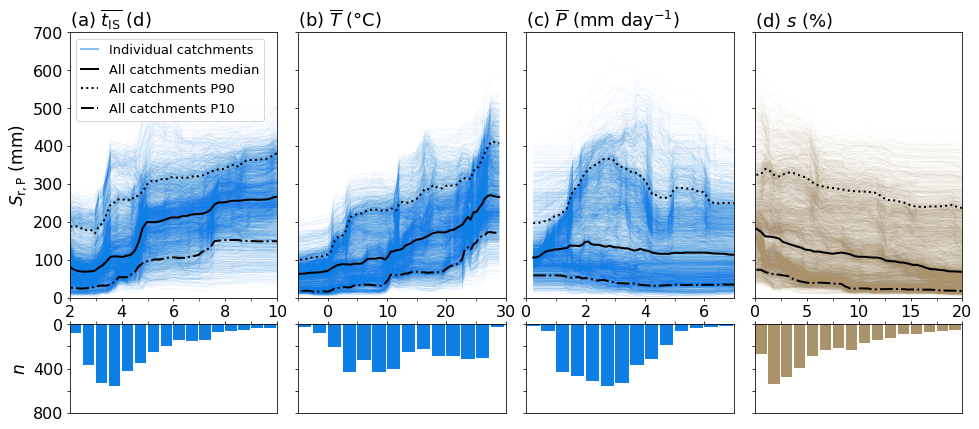

In [50]:
# SLOPE IPV ASI
# ices based on 0-1 range, plot limited range - interpolated
var = ['$\overline{t_\mathrm{IS}}$','$\overline{T}$','$\overline{P}$','$s$']
units = ['d','$\degree$C','mm $\mathrm{day}^{-1}$','%']
abcd = ['(a)','(b)','(c)','(d)']

major_t = [0,10,20,30]
minor_t = [-5,5,15,25]
major_idu = [2,4,6,8,10]
minor_idu = [3,5,7,9]
major_p = [0,2,4,6]
minor_p = [1,3,5]
major_slp = [0,5,10,15,20]
minor_slp = [2.5,7.5,12.5,17.5]
majors = [major_idu,major_t,major_p,major_slp]
minors = [minor_idu,minor_t,minor_p,minor_slp]

xlims = [[2,10],[-5,30],[0,7],[0,20]]

binst = np.arange(-10,32.5,2.5)
binsidu = np.arange(2,10.5,0.5)
binsp = np.arange(0,7.5,0.5)
binsslp = np.arange(0,21.25,1.25)
binslist = [binsidu,binst,binsp,binsslp]

# plot pdp TEST ALL CVS COMBINED
X = np.concatenate([X_train,X_test])
ddf = pd.concat([df_train,df_test])
fig3, ax = plt.subplots(2,len(features), figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.15,wspace=0.1)
for k in range(len(features)):
    ice0 = icsi[k]
    c = c1#'tab:blue'
    if (k==3):
        c = c3
    for i in ice0.index:
        ax[0,k].plot(ice0.columns.values, ice0.loc[i],color=c,alpha=0.5,linestyle='-',linewidth=0.05)    
    
    ax[0,k].plot(ice0.columns.values, -1*ice0.iloc[0],color=c,alpha=0.5,linestyle='-',linewidth=2,label='Individual catchments')
    ax[0,k].plot(ice0.columns.values, ice0.median(axis=0),color='k',linestyle='-',linewidth=2, label='All catchments median')
    ax[0,k].plot(ice0.columns.values, np.quantile(ice0,0.9,axis=0),color='k',linestyle=':',linewidth=2, label='All catchments P90')
    ax[0,k].plot(ice0.columns.values, np.quantile(ice0,0.1,axis=0),color='k',linestyle='-.',linewidth=2, label='All catchments P10')
    
    ax[0,k].set_title(f'{abcd[k]} {var[k]} ({units[k]})',size=18, loc='left')
    ax[0,0].set_ylabel('$S_\mathrm{r,P}$ (mm)',size=17)
    ax[0,k].set_ylim(0,700)
    ax[0,k].set_xlim(xlims[k])
    ax[0,k].tick_params(axis='both',labelsize=16)
    ax[0,k].tick_params(which='major', length=3)
    ax[0,k].tick_params(which='minor', length=3)
    ax[0,k].set_xticks(ticks=majors[k])
    ax[0,k].set_xticks(ticks=minors[k],minor=True)
    ax[0,k].set_yticks(ticks=[0,100,200,300,400,500,600,700])
    ax[0,k].set_yticklabels(['','','','','','','',''])
    ax[0,0].set_yticklabels(['0','100','200','300','400','500','600','700'])
    ax[0,0].legend(loc='upper left',fontsize=13,handlelength=1.3)
           
    bins = binslist[k]
    ax[1,k].hist(df.loc[:,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]),color=c)
    ax[1,k].invert_yaxis()
    ax[1,k].xaxis.tick_top()
    ax[1,k].axes.get_xaxis().set_ticklabels([])
    ax[1,0].set_ylabel('$n$',size=17)
    ax[1,k].tick_params(axis='both', labelsize=16)
    ax[1,k].set_ylim(800,0)
    ax[1,k].set_yticks([0,200,400,600,800])
    ax[1,k].set_yticklabels(['','','','',''])
    ax[1,0].set_yticklabels(['0','','400','','800'])
    ax[1,k].set_xlim(xlims[k])
    ax[1,k].set_xticks(ticks=majors[k])
    ax[1,k].set_xticks(ticks=minors[k],minor=True)
    ax[1,k].tick_params(which='major', length=3)
    ax[1,k].tick_params(which='minor', length=3)
    
fig3.savefig(f'{fig_dir}/fig04.jpg',bbox_inches='tight',dpi=600)

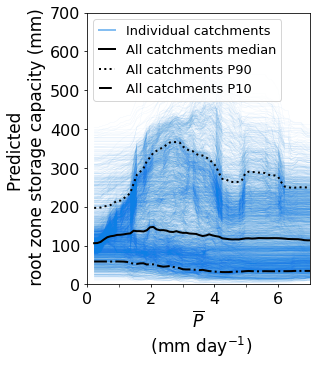

In [51]:
# P only
X = np.concatenate([X_train,X_test])
ddf = pd.concat([df_train,df_test])
fig3, ax = plt.subplots(1,1, figsize=(4,5))
k=2
ice0 = icsi[k]

c = c1
for i in ice0.index:
    ax.plot(ice0.columns.values, ice0.loc[i],color=c,alpha=0.5,linestyle='-',linewidth=0.05)    

ax.plot(ice0.columns.values, -1*ice0.iloc[0],color=c,alpha=0.5,linestyle='-',linewidth=2,label='Individual catchments')
ax.plot(ice0.columns.values, ice0.median(axis=0),color='k',linestyle='-',linewidth=2, label='All catchments median')
ax.plot(ice0.columns.values, np.quantile(ice0,0.9,axis=0),color='k',linestyle=':',linewidth=2, label='All catchments P90')
ax.plot(ice0.columns.values, np.quantile(ice0,0.1,axis=0),color='k',linestyle='-.',linewidth=2, label='All catchments P10')

ax.set_xlabel(f'{var[k]} \n ({units[k]})',size=17, loc='center')
ax.set_ylabel('Predicted \n root zone storage capacity (mm)',size=17)
ax.set_ylim(0,700)
ax.set_xlim(xlims[k])
ax.tick_params(axis='both',labelsize=16)
ax.tick_params(which='major', length=3)
ax.tick_params(which='minor', length=3)
ax.set_xticks(ticks=majors[k])
ax.set_xticks(ticks=minors[k],minor=True)
ax.set_yticks(ticks=[0,100,200,300,400,500,600,700])
ax.set_yticklabels(['','','','','','','',''])
ax.set_yticklabels(['0','100','200','300','400','500','600','700'])
ax.legend(loc='upper left',fontsize=13,handlelength=1.3)
        
fig3.savefig(f'{fig_dir}/fig04_p.png',bbox_inches='tight',dpi=600,transparent=True)

## MAKE MANUAL SPLITS

In [87]:
c1 = '#FF1F5B'
# c2 = '#009ADE'
# c1 = '#AF58BA'
c4 = '#FFC61E'

In [53]:
# get ices
# idu_mean
k = 0
ice_idu0 = ics[0][k]
ice_idu1 = ics[1][k]
ice_idu2 = ics[2][k]
ice_idu3 = ics[3][k]
ice_idu4 = ics[4][k]

pdp_idu0 = ps[0][k]
pdp_idu1 = ps[1][k]
pdp_idu2 = ps[2][k]
pdp_idu3 = ps[3][k]
pdp_idu4 = ps[4][k]

# t_mean
k = 1 
ice_t0 = ics[0][k]
ice_t1 = ics[1][k]
ice_t2 = ics[2][k]
ice_t3 = ics[3][k]
ice_t4 = ics[4][k]

pdp_t0 = ps[0][k]
pdp_t1 = ps[1][k]
pdp_t2 = ps[2][k]
pdp_t3 = ps[3][k]
pdp_t4 = ps[4][k]

# p_mean
k = 2
ice_p0 = ics[0][k]
ice_p1 = ics[1][k]
ice_p2 = ics[2][k]
ice_p3 = ics[3][k]
ice_p4 = ics[4][k]

pdp_p0 = ps[0][k]
pdp_p1 = ps[1][k]
pdp_p2 = ps[2][k]
pdp_p3 = ps[3][k]
pdp_p4 = ps[4][k]

# slp
k = 3 
ice_slp0 = ics[0][k]
ice_slp1 = ics[1][k]
ice_slp2 = ics[2][k]
ice_slp3 = ics[3][k]
ice_slp4 = ics[4][k]

pdp_slp0 = ps[0][k]
pdp_slp1 = ps[1][k]
pdp_slp2 = ps[2][k]
pdp_slp3 = ps[3][k]
pdp_slp4 = ps[4][k]


## 2 regimes

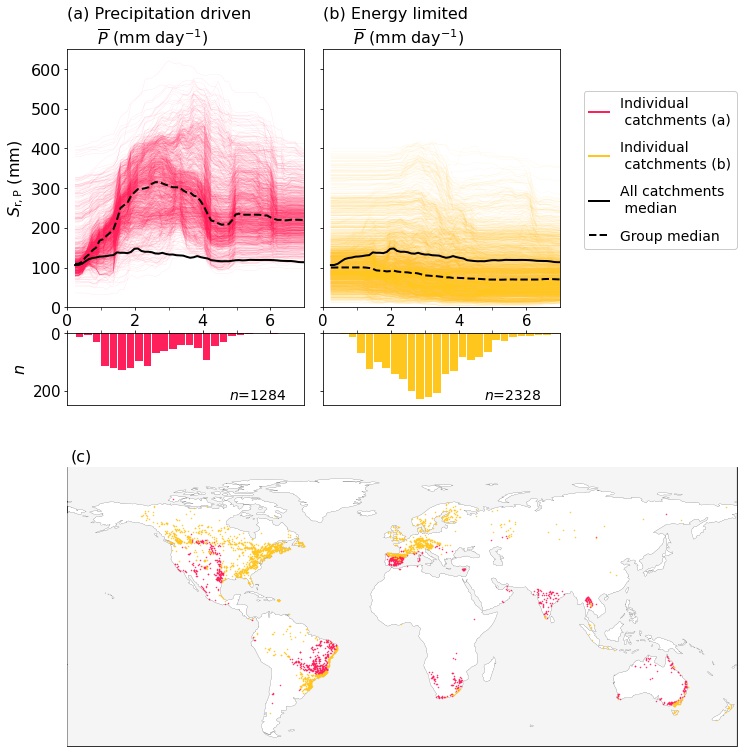

In [99]:
# make plots - ices - pmean - 2 different regimes - interpolated - SLOPE 
var = ['idu_mean','t_mean','p_mean','slp_mean']
var2 = ['$I_\mathrm{ISD}$','$\overline{T}$','$\overline{P}$','$s$']
units = ['d','$\degree$C','mm $\mathrm{day}^{-1}$','%']
major_t = [0,10,20,30]
minor_t = [-5,5,15,25]
major_idu = [2,4,6,8,10]
minor_idu = [3,5,7,9]
major_p = [0,2,4,6]
minor_p = [1,3,5]
major_slp = [0,5,10,15,20]
minor_slp = [2.5,7.5,12.5,17.5]
majors = [major_idu,major_t,major_p,major_slp]
minors = [minor_idu,minor_t,minor_p,minor_slp]

xlims = [[2,10],[-5,30],[0,7],[0,20]]

binst = np.arange(-10,32.5,2.5)
binsidu = np.arange(2,10.5,0.5)
binsp = np.arange(0,7.5,0.25)
binsslp = np.arange(0,21.25,1.25)
binslist = [binsidu,binst,binsp,binsslp]

m=2
k=2
grs1=[]
grs2=[]
grs3=[]
grs4=[]
fig = plt.figure(figsize=(12,15))
gs = fig.add_gridspec(ncols=3, nrows=5,height_ratios=[2.5,1,0.7,0.2,5],width_ratios=[1.5,1.5,1])
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax7 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[2:4, 0])
ax4 = fig.add_subplot(gs[2:4, 1])
ax8 = fig.add_subplot(gs[2:4, 2])
ax6 = fig.add_subplot(gs[4,:],projection=ccrs.PlateCarree())

ax7.axis('off')
ax8.axis('off')

ax1.set_title(f'(a) Precipitation driven \n      {var2[m]} ({units[m]})',size=16, loc='left')
ax1.set_ylabel('$S_\mathrm{r,P}$ (mm)',size=16)
ax1.set_ylim(0,650)
ax1.tick_params(axis='both', labelsize=15)  
ax1.set_xlim(xlims[m])
ax1.tick_params(axis='both',labelsize=16)
ax1.tick_params(which='major', length=3)
ax1.tick_params(which='minor', length=3)
ax1.set_xticks(ticks=majors[k])
ax1.set_xticks(ticks=minors[k],minor=True)
ax1.set_yticks([0,100,200,300,400,500,600])
ax1.set_yticklabels(['','','','','','',''])
ax1.set_yticklabels(['0','100','200','300','400','500','600'])

ax3.set_title(f'(b) Energy limited \n      {var2[m]} ({units[m]})',size=16, loc='left')
ax3.set_ylim(0,650)
ax3.tick_params(axis='both', labelsize=15)  
ax3.set_xlim(xlims[m])
ax3.tick_params(axis='both',labelsize=16)
ax3.tick_params(which='major', length=3)
ax3.tick_params(which='minor', length=3)
ax3.set_xticks(ticks=majors[k])
ax3.set_xticks(ticks=minors[k],minor=True)
ax3.tick_params(axis='both', labelsize=15)
ax3.set_yticks([0,100,200,300,400,500,600])
ax3.set_yticklabels(['','','','','','',''])

ax6.coastlines(linewidth=0.1)
ax6.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax6.set_global()
ax6.set_xlim(-180,180)
ax6.set_ylim(-60,90)
ax6.text(-178,93, f'(c)',zorder=101,size=16)
    
plt.subplots_adjust(wspace=0.09,hspace=-0.2)
ice_p = icsi[m]

# define groups
pos = []
neg = []
slp = (ice_p.iloc[:,-1] - ice_p.iloc[:,0])/(ice_p.columns[-1] - ice_p.columns[0])
for i in ice_p.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
nm = slp.loc[neg].mean()
p1 = slp[slp>pm].index
p2 = slp[slp<pm].index

p = ice_p.index
p1 = []
p2 = []
p3 = []
p4 = []
grr = []
r = []
rr = []
             
for i in p:
    if((ice_p.loc[i].iloc[30] - ice_p.loc[i].iloc[0])/(ice_p.columns[30] - ice_p.columns[0]) < 20):
        p3.append(i)
    else:
        p1.append(i)

gr1 = p1
gr3 = p3
ice = ice_p
ylim = 250
mm = 0
grs1.append(gr1)
grs3.append(gr3)
if (len(gr1)>0):
    gr = gr1
    j = 0
    for i in gr:
        ax1.plot(ice.columns.values, ice.loc[i],color=c1,linestyle='-',linewidth=0.08,alpha=0.5,zorder=1)
    ax1.plot(ice.columns.values, ice.loc[gr].median(),color='k',linestyle='--',linewidth=2,zorder=2)
    ax1.plot(ice.columns.values, ice.median(),color='k',linestyle='-',linewidth=2,zorder=2)

if (len(gr3)>0):
    gr = gr3
    j = 2
    for i in gr:
        ax3.plot(ice.columns.values, ice.loc[i],color=c4,linestyle='-',linewidth=0.08,alpha=0.5,zorder=1)
    ax3.plot(ice.columns.values, ice.loc[gr].median(),color='k',linestyle='--',linewidth=2,zorder=2)
    ax3.plot(ice.columns.values, ice.median(),color='k',linestyle='-',linewidth=2,zorder=2)

ddf = df.loc[ice.index]
ax6.plot(ddf.loc[gr1].lon, ddf.loc[gr1].lat,'o', markeredgecolor=c1, markerfacecolor=c1,markersize=0.5,zorder=102)
ax6.plot(ddf.loc[gr3].lon, ddf.loc[gr3].lat,'o', markeredgecolor=c4, markerfacecolor=c4,markersize=0.5,zorder=102)

bins = binslist[m]

ax2.hist(df.loc[gr1,features[m]],bins=bins,width=0.9*(bins[1]-bins[0]),color=c1)
ax2.invert_yaxis()
ax2.xaxis.tick_top()
ax2.axes.get_xaxis().set_ticklabels([])
ax2.set_ylabel('$n$',size=16)
ax2.tick_params(axis='both', labelsize=15)
ax2.set_ylim(ylim,0)
ax2.text(ice.columns.values[-56],ylim-20,f'$n$={len(gr1)}',size=14,zorder=10)
ax2.set_xlim(xlims[m])
ax2.set_xticks(ticks=majors[m])
ax2.set_xticks(ticks=minors[m],minor=True)
ax2.tick_params(which='major', length=3)
ax2.tick_params(which='minor', length=3)

ax4.hist(df.loc[gr3,features[m]],bins=bins,width=0.9*(bins[1]-bins[0]),color=c4)
ax4.invert_yaxis()
ax4.xaxis.tick_top()
ax4.axes.get_xaxis().set_ticklabels([])
ax4.tick_params(axis='both', labelsize=15)
ax4.set_ylim(ylim,0)
ax4.set_yticklabels([])
ax4.text(ice.columns.values[-56],ylim-20,f'$n$={len(gr3)}',size=14,zorder=10)
ax4.set_xlim(xlims[m])
ax4.set_xticks(ticks=majors[m])
ax4.set_xticks(ticks=minors[m],minor=True)
ax4.tick_params(which='major', length=3)
ax4.tick_params(which='minor', length=3)

ax3.plot([-1,-1],[-4,-4],color=c1,linestyle='-',linewidth=2, label='Individual \n catchments (a)')
ax3.plot([-1,-1],[-4,-4],color=c4,linestyle='-',linewidth=2, label='Individual \n catchments (b)')
ax3.plot([-1,-1],[-4,-4],color='k',linestyle='-',linewidth=2, label='All catchments \n median')
ax3.plot([-1,-1],[-4,-4],color='k',linestyle='--',linewidth=2, label='Group median')

legend=ax3.legend(bbox_to_anchor=(1.07, 0.2),fontsize=14,handlelength=1.4,labelspacing=1)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0))
fig.savefig(f'{fig_dir}/fig05.jpg',bbox_inches='tight',dpi=300)

In [90]:
# get other catchment characterstics for regimes
def f(gr):
    d = pd.DataFrame(index=['mean','median','std','q25','q75'], columns=['t_mean','idu_mean','slp_mean','tc','p_mean','sr_20'])
    dd = df.loc[gr]
    d.loc['mean'] = np.round([dd.t_mean.mean(), dd.idu_mean.mean(), dd.slp_mean.mean(), dd.tc.mean(), dd.p_mean.mean(), dd.sr_20.mean()],2)
    d.loc['median'] = np.round([dd.t_mean.median(), dd.idu_mean.median(), dd.slp_mean.median(), dd.tc.median(), dd.p_mean.median(), dd.sr_20.median()],2)
    d.loc['std'] = np.round([dd.t_mean.std(), dd.idu_mean.std(), dd.slp_mean.std(), dd.tc.std(), dd.p_mean.std(), dd.sr_20.std()],2)
    d.loc['q25'] = np.round([dd.t_mean.quantile(0.25), dd.idu_mean.quantile(0.25), dd.slp_mean.quantile(0.25), dd.tc.quantile(0.25), dd.p_mean.quantile(0.25), dd.sr_20.quantile(0.25)],2)
    d.loc['q75'] = np.round([dd.t_mean.quantile(0.75), dd.idu_mean.quantile(0.75), dd.slp_mean.quantile(0.75), dd.tc.quantile(0.75), dd.p_mean.quantile(0.75), dd.sr_20.quantile(0.75)],2)
    return d

In [91]:
f(gr1)

,t_mean,idu_mean,slp_mean,tc,p_mean,sr_20
mean,18.4,7.97,6.45,0.15,2.51,258.12
median,19.48,6.66,4.98,0.13,2.25,243.03
std,6.54,5.56,5.05,0.1,1.22,113.19
q25,13.59,5.56,2.74,0.08,1.55,184.09
q75,23.94,8.24,9.0,0.2,3.36,326.47


In [92]:
f(gr2)

,t_mean,idu_mean,slp_mean,tc,p_mean,sr_20
mean,NaN,NaN,NaN,NaN,NaN,NaN
median,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
q25,NaN,NaN,NaN,NaN,NaN,NaN
q75,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
f(gr3)

,t_mean,idu_mean,slp_mean,tc,p_mean,sr_20
mean,9.75,3.71,8.1,0.38,3.09,92.65
median,8.52,3.64,5.93,0.39,2.99,71.04
std,7.56,0.86,6.99,0.14,1.24,80.52
q25,4.26,3.11,2.69,0.27,2.26,32.9
q75,14.4,4.23,11.56,0.49,3.76,127.76


## TC CLASSIFICATION

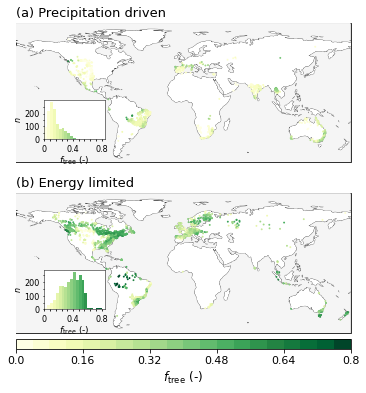

In [97]:
# group by treecover
cmap = ListedColormap([c1,c4])
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
features = ['t_mean','idu_mean','p_mean','slp_mean','sr_20','tc']
df1 = df.loc[list(itertools.chain.from_iterable(grs1))] 
df3 = df.loc[list(itertools.chain.from_iterable(grs3))]

bounds = np.linspace(0,0.8,21)
bounds2 = np.linspace(0,0.8,6)

n1 = []
n3 = []
for i in range(len(bounds)):
    if (i<(len(bounds)-1)):
        nn1 = len(df1[(df1.tc<bounds[i+1])&(df1.tc>=bounds[i])])
        n1.append(nn1)
        nn3 = len(df3[(df3.tc<bounds[i+1])&(df3.tc>=bounds[i])])
        n3.append(nn3)
    else:
        nn1 = len(df1[(df1.tc>=bounds[i])])
        n1.append(nn1)
        nn3 = len(df3[(df3.tc>=bounds[i])])
        n3.append(nn3)


cmap_ylgn = cm.get_cmap('YlGn',21)
norm = mpl.colors.BoundaryNorm(bounds, cmap_ylgn.N)

colors=[]
for i in range(len(bounds)):
    colors.append(cmap_ylgn(i)) 


fig = plt.figure(figsize=(6,15))
gs = fig.add_gridspec(ncols=1, nrows=2,height_ratios=[1,0.7])
ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1, 0],projection=ccrs.PlateCarree())
plt.subplots_adjust(hspace=-0.98)

# RED
ax = ax1
ax.coastlines(linewidth=0.3)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df1.lon,df1.lat,c=df1['tc'],s=0.8,cmap=cmap_ylgn, norm=norm,zorder=101)
ax.set_title('(a) Precipitation driven',size=13,loc='left')

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar(np.arange(0,21,1),n1,width=1,color=colors)
iax.set_xticks(np.arange(-0.5,20,2))
iax.set_xticklabels(['0','','','','','0.4','','','','','0.8'])
iax.set_xlim(-0.5,20.5)
iax.set_yticks([0,50,100,150,200,250])
iax.set_yticklabels(['0','','100','','200',''])
iax.set_xlabel('$f_\mathrm{tree}$ (-)',size=9,labelpad=1)
iax.set_ylabel('$n$',size=8,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=8)

# BLUE
ax = ax3
ax.coastlines(linewidth=0.3)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df3.lon,df3.lat,c=df3['tc'],s=0.8,cmap=cmap_ylgn, norm=norm,zorder=101)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal',spacing='proportional',extend='neither',aspect=35, pad=0.01, norm=norm,ticks=bounds2)
cbar.set_ticklabels(bounds2,size=11)
cbar.set_label('$f_\mathrm{tree}$ (-)',size=12)
ax.set_title('(b) Energy limited',size=13,loc='left')

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar(np.arange(0,21,1),n3,width=1,color=colors)
iax.set_xticks(np.arange(-0.5,20,2))
iax.set_xticklabels(['0','','','','','0.4','','','','','0.8'])
iax.set_xlim(-0.5,20.5)
iax.set_yticks([0,50,100,150,200,250])
iax.set_yticklabels(['0','','100','','200',''])
iax.set_xlabel('$f_\mathrm{tree}$ (-)',size=9,labelpad=1)
iax.set_ylabel('$n$',size=8,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=8)
fig.savefig(f'{fig_dir}/fig06.jpg',bbox_inches='tight',dpi=600)

## 3 regimes

In [ ]:
# make plots - ices - pmean - 3 different regimes - interpolated - SLOPE - UPDATED SPLIT CRITERIA
var = ['idu_mean','t_mean','p_mean','slp_mean']
var2 = ['$I_\mathrm{ISD}$','$\overline{T}$','$\overline{P}$','$s$']
# pcavar = ['$I_\mathrm{ISD}$','$\overline{T}$','$\overline{P}$','$s$','$S_\mathrm{r}$']
units = ['d','$\degree$C','mm $\mathrm{day}^{-1}$','%']
major_t = [0,10,20,30]
minor_t = [-5,5,15,25]
major_idu = [2,4,6,8,10]
minor_idu = [3,5,7,9]
major_p = [0,2,4,6]
minor_p = [1,3,5]
major_slp = [0,5,10,15,20]
minor_slp = [2.5,7.5,12.5,17.5]
majors = [major_idu,major_t,major_p,major_slp]
minors = [minor_idu,minor_t,minor_p,minor_slp]

xlims = [[2,10],[-5,30],[0,7],[0,20]]

binst = np.arange(-10,32.5,2.5)
binsidu = np.arange(2,10.5,0.5)
binsp = np.arange(0,7.5,0.25)
binsslp = np.arange(0,21.25,1.25)
binslist = [binsidu,binst,binsp,binsslp]

m=2
k=2
grs1=[]
grs2=[]
grs3=[]
grs4=[]
fig = plt.figure(figsize=(12,15))
gs = fig.add_gridspec(ncols=3, nrows=5,height_ratios=[2.5,1,0.7,0.2,5],width_ratios=[1,1,1])
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax7 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[2:4, 0])
ax4 = fig.add_subplot(gs[2:4, 1])
ax8 = fig.add_subplot(gs[2:4, 2])
ax6 = fig.add_subplot(gs[4,:],projection=ccrs.PlateCarree())

ax1.set_title(f'(a) Precipitation driven \n      {var2[m]} ({units[m]})',size=15, loc='left')
ax1.set_ylabel('$S_\mathrm{r,P}$ (mm)',size=16)
ax1.set_ylim(0,740)
ax1.tick_params(axis='both', labelsize=15)  
ax1.set_xlim(xlims[m])
ax1.tick_params(axis='both',labelsize=16)
ax1.tick_params(which='major', length=3)
ax1.tick_params(which='minor', length=3)
ax1.set_xticks(ticks=majors[k])
ax1.set_xticks(ticks=minors[k],minor=True)
ax1.set_yticks([0,100,200,300,400,500,600,700])
ax1.set_yticklabels(['','','','','','','',''])
ax1.set_yticklabels(['0','100','200','300','400','500','600','700'])

ax3.set_title(f'(b) Transitional \n      {var2[m]} ({units[m]})',size=15, loc='left')
ax3.set_ylim(0,740)
ax3.tick_params(axis='both', labelsize=15)  
ax3.set_xlim(xlims[m])
ax3.tick_params(axis='both',labelsize=16)
ax3.tick_params(which='major', length=3)
ax3.tick_params(which='minor', length=3)
ax3.set_xticks(ticks=majors[k])
ax3.set_xticks(ticks=minors[k],minor=True)
ax3.tick_params(axis='both', labelsize=15)
ax3.set_yticks([0,100,200,300,400,500,600,700])
ax3.set_yticklabels(['','','','','','','',''])

ax7.set_title(f'(c) Energy limited \n      {var2[m]} ({units[m]})',size=15, loc='left')
ax7.set_ylim(0,740)
ax7.tick_params(axis='both', labelsize=15)  
ax7.set_xlim(xlims[m])
ax7.tick_params(axis='both',labelsize=16)
ax7.tick_params(which='major', length=3)
ax7.tick_params(which='minor', length=3)
ax7.set_xticks(ticks=majors[k])
ax7.set_xticks(ticks=minors[k],minor=True)
ax7.tick_params(axis='both', labelsize=15)
ax7.set_yticks([0,100,200,300,400,500,600,700])
ax7.set_yticklabels(['','','','','','','',''])

ax6.coastlines(linewidth=0.1)
ax6.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax6.set_global()
ax6.set_xlim(-180,180)
ax6.set_ylim(-60,90)
ax6.text(-178,93, f'(d)',zorder=101,size=15)
    
plt.subplots_adjust(wspace=0.09,hspace=-0.2)
ice_p = icsi[m]

# define groups
pos = []
neg = []
slp = (ice_p.iloc[:,-1] - ice_p.iloc[:,0])/(ice_p.columns[-1] - ice_p.columns[0])
for i in ice_p.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
nm = slp.loc[neg].mean()
p1 = slp[slp>pm].index
p2 = slp[slp<pm].index

p = ice_p.index
p1 = []
p2 = []
p3 = []
p4 = []
grr = []
r = []
rr = []
             
for i in p:
    if((ice_p.loc[i].iloc[30] - ice_p.loc[i].iloc[0])/(ice_p.columns[30] - ice_p.columns[0]) < 0):
        p3.append(i)
    else:
        if(((ice_p.loc[i].iloc[30] - ice_p.loc[i].iloc[0])/(ice_p.columns[30] - ice_p.columns[0]) > 50) or ((ice_p.loc[i].iloc[40] - ice_p.loc[i].iloc[0])/(ice_p.columns[40] - ice_p.columns[0]) >30)):
            p1.append(i)
        else:
            if((ice_p.loc[i].iloc[0]>250)and((ice_p.loc[i].iloc[30] - ice_p.loc[i].iloc[0])/(ice_p.columns[30] - ice_p.columns[0]) >30)):
                p1.append(i)
            else:
                p2.append(i)

gr1 = p1
gr2 = p2
gr3 = p3
ice = ice_p
ylim = 220
mm = 0
grs1.append(gr1)
grs2.append(gr2)
grs3.append(gr3)
if (len(gr1)>0):
    gr = gr1
    j = 0
    for i in gr:
        ax1.plot(ice.columns.values, ice.loc[i],color=c1,linestyle='-',linewidth=0.08,alpha=0.5,zorder=1)
    ax1.plot(ice.columns.values, ice.loc[gr].median(),color='k',linestyle='--',linewidth=2,zorder=2)
    ax1.plot(ice.columns.values, ice.median(),color='k',linestyle='-',linewidth=2,zorder=2)

if (len(gr2)>0):
    gr = gr2
    j = 1
    for i in gr:
        ax3.plot(ice.columns.values, ice.loc[i],color=c4,linestyle='-',linewidth=0.08,alpha=0.5,zorder=1)
    ax3.plot(ice.columns.values, ice.loc[gr].median(),color='k',linestyle='--',linewidth=2,zorder=2)
    ax3.plot(ice.columns.values, ice.median(),color='k',linestyle='-',linewidth=2,zorder=2)

if (len(gr3)>0):
    gr = gr3
    j = 2
    for i in gr:
        ax7.plot(ice.columns.values, ice.loc[i],color=c2,linestyle='-',linewidth=0.08,alpha=0.5,zorder=1)
    ax7.plot(ice.columns.values, ice.loc[gr].median(),color='k',linestyle='--',linewidth=2,zorder=2)
    ax7.plot(ice.columns.values, ice.median(),color='k',linestyle='-',linewidth=2,zorder=2)

ddf = df.loc[ice.index]
ax6.plot(ddf.loc[gr1].lon, ddf.loc[gr1].lat,'o', markeredgecolor=c1, markerfacecolor=c1,markersize=0.5,zorder=102)
ax6.plot(ddf.loc[gr2].lon, ddf.loc[gr2].lat,'o', markeredgecolor=c4, markerfacecolor=c4,markersize=0.5,zorder=102)
ax6.plot(ddf.loc[gr3].lon, ddf.loc[gr3].lat,'o', markeredgecolor=c2, markerfacecolor=c2,markersize=0.5,zorder=102)

bins = binslist[m]

ax2.hist(df.loc[gr1,features[m]],bins=bins,width=0.9*(bins[1]-bins[0]),color=c1)
ax2.invert_yaxis()
ax2.xaxis.tick_top()
ax2.axes.get_xaxis().set_ticklabels([])
ax2.set_ylabel('$n$',size=16)
ax2.tick_params(axis='both', labelsize=15)
ax2.set_ylim(ylim,0)
ax2.text(ice.columns.values[-56],ylim-20,f'$n$={len(gr1)}',size=14,zorder=10)
ax2.set_xlim(xlims[m])
ax2.set_xticks(ticks=majors[m])
ax2.set_xticks(ticks=minors[m],minor=True)
ax2.tick_params(which='major', length=3)
ax2.tick_params(which='minor', length=3)

ax4.hist(df.loc[gr2,features[m]],bins=bins,width=0.9*(bins[1]-bins[0]),color=c4)
ax4.invert_yaxis()
ax4.xaxis.tick_top()
ax4.axes.get_xaxis().set_ticklabels([])
ax4.tick_params(axis='both', labelsize=15)
ax4.set_ylim(ylim,0)
ax4.set_yticklabels([])
ax4.text(ice.columns.values[-56],ylim-20,f'$n$={len(gr2)}',size=14,zorder=10)
ax4.set_xlim(xlims[m])
ax4.set_xticks(ticks=majors[m])
ax4.set_xticks(ticks=minors[m],minor=True)
ax4.tick_params(which='major', length=3)
ax4.tick_params(which='minor', length=3)

ax8.hist(df.loc[gr3,features[m]],bins=bins,width=0.9*(bins[1]-bins[0]),color=c2)
ax8.invert_yaxis()
ax8.xaxis.tick_top()
ax8.axes.get_xaxis().set_ticklabels([])
ax8.tick_params(axis='both', labelsize=15)
ax8.set_ylim(ylim,0)
ax8.set_yticklabels([])
ax8.text(ice.columns.values[-56],ylim-20,f'$n$={len(gr3)}',size=14,zorder=10)
ax8.set_xlim(xlims[m])
ax8.set_xticks(ticks=majors[m])
ax8.set_xticks(ticks=minors[m],minor=True)
ax8.tick_params(which='major', length=3)
ax8.tick_params(which='minor', length=3)

ax1.plot([-1,-1],[-4,-4],color=c1,linestyle='-',linewidth=2, label='Individual catchments')
ax1.plot([-1,-1],[-4,-4],color='k',linestyle='-',linewidth=2, label='All catchments median')
ax1.plot([-1,-1],[-4,-4],color='k',linestyle='--',linewidth=2, label='Group median')
ax3.plot([-1,-1],[-4,-4],color=c4,linestyle='-',linewidth=2, label='Individual catchments')
ax3.plot([-1,-1],[-4,-4],color='k',linestyle='-',linewidth=2, label='All catchments median')
ax3.plot([-1,-1],[-4,-4],color='k',linestyle='--',linewidth=2, label='Group median')
ax7.plot([-1,-1],[-4,-4],color=c2,linestyle='-',linewidth=2, label='Individual catchments')
ax7.plot([-1,-1],[-4,-4],color='k',linestyle='-',linewidth=2, label='All catchments median')
ax7.plot([-1,-1],[-4,-4],color='k',linestyle='--',linewidth=2, label='Group median')

legend=ax1.legend(loc='upper left',fontsize=12.5,handlelength=1.3)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0))
ax3.legend(loc='upper left',fontsize=12.5,handlelength=1.3)
ax7.legend(loc='upper left',fontsize=12.5,handlelength=1.3)
fig.savefig(f'{fig_dir}/fig05.jpg',bbox_inches='tight',dpi=300)

In [ ]:
# group by treecover
cmap = ListedColormap([c1,c4,c2])
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
features = ['t_mean','idu_mean','p_mean','slp_mean','sr_20','tc']
df1 = df.loc[list(itertools.chain.from_iterable(grs1))] 
df2 = df.loc[list(itertools.chain.from_iterable(grs2))] 
df3 = df.loc[list(itertools.chain.from_iterable(grs3))]

bounds = np.linspace(0,0.8,21)
bounds2 = np.linspace(0,0.8,6)

n1 = []
n2 = []
n3 = []
for i in range(len(bounds)):
    if (i<(len(bounds)-1)):
        nn1 = len(df1[(df1.tc<bounds[i+1])&(df1.tc>=bounds[i])])
        n1.append(nn1)
        nn2 = len(df2[(df2.tc<bounds[i+1])&(df2.tc>=bounds[i])])
        n2.append(nn2)
        nn3 = len(df3[(df3.tc<bounds[i+1])&(df3.tc>=bounds[i])])
        n3.append(nn3)
    else:
        nn1 = len(df1[(df1.tc>=bounds[i])])
        n1.append(nn1)
        nn2 = len(df2[(df2.tc>=bounds[i])])
        n2.append(nn2)
        nn3 = len(df3[(df3.tc>=bounds[i])])
        n3.append(nn3)


cmap_ylgn = cm.get_cmap('YlGn',21)
norm = mpl.colors.BoundaryNorm(bounds, cmap_ylgn.N)

colors=[]
for i in range(len(bounds)):
    colors.append(cmap_ylgn(i)) 


fig = plt.figure(figsize=(6,15))
gs = fig.add_gridspec(ncols=1, nrows=3,height_ratios=[1,1,0.74])
ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1, 0],projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[2, 0],projection=ccrs.PlateCarree())
plt.subplots_adjust(hspace=-0.8)

# RED
ax = ax1
ax.coastlines(linewidth=0.3)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df1.lon,df1.lat,c=df1['tc'],s=1,cmap=cmap_ylgn, norm=norm,zorder=101)
ax.set_title('(a) Precipitation driven',size=13,loc='left')

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar(np.arange(0,21,1),n1,width=1,color=colors)
iax.set_xticks(np.arange(-0.5,20,2))
iax.set_xticklabels(['0','','','','','0.4','','','','','0.8'])
iax.set_xlim(-0.5,20.5)
iax.set_yticks([0,50,100,150,200,250])
iax.set_yticklabels(['0','','100','','200',''])
iax.set_xlabel('$f_\mathrm{tree}$ (-)',size=9,labelpad=1)
iax.set_ylabel('$n$',size=8,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=8)

# Yellow
# ax = fig.add_subplot(312,projection=ccrs.PlateCarree())
ax = ax2
ax.coastlines(linewidth=0.3)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df2.lon,df2.lat,c=df2['tc'],s=1,cmap=cmap_ylgn, norm=norm,zorder=101)
ax.set_title('(b) Transitional',size=13,loc='left')

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar(np.arange(0,21,1),n2,width=1,color=colors)
iax.set_xticks(np.arange(-0.5,20,2))
iax.set_xticklabels(['0','','','','','0.4','','','','','0.8'])
iax.set_xlim(-0.5,20.5)
iax.set_yticks([0,50,100,150,200,250])
iax.set_yticklabels(['0','','100','','200',''])
iax.set_xlabel('$f_\mathrm{tree}$ (-)',size=9,labelpad=1)
iax.set_ylabel('$n$',size=8,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=8)

# BLUE
ax = ax3
ax.coastlines(linewidth=0.3)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df3.lon,df3.lat,c=df3['tc'],s=1,cmap=cmap_ylgn, norm=norm,zorder=101)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal',spacing='proportional',extend='neither',aspect=30, pad=0.02, norm=norm,ticks=bounds2)
cbar.set_ticklabels(bounds2,size=12)
cbar.set_label('$f_\mathrm{tree}$ (-)',size=13)
ax.set_title('(c) Energy limited',size=13,loc='left')

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar(np.arange(0,21,1),n3,width=1,color=colors)
iax.set_xticks(np.arange(-0.5,20,2))
iax.set_xticklabels(['0','','','','','0.4','','','','','0.8'])
iax.set_xlim(-0.5,20.5)
iax.set_yticks([0,50,100,150,200,250])
iax.set_yticklabels(['0','','100','','200',''])
iax.set_xlabel('$f_\mathrm{tree}$ (-)',size=9,labelpad=1)
iax.set_ylabel('$n$',size=8,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=8)
fig.savefig(f'{fig_dir}/fig06.jpg',bbox_inches='tight',dpi=600)